In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Load the data
print("Loading data...")
df = pd.read_csv('../project_data/PAS+crime+extra_final.csv')

# Drop rows where 'Q60' is NaN and filter out 'Q60' values >= 95
print("Cleaning data...")
df.dropna(subset=['Q60'], inplace=True)
df = df[df['Q60'] < 95]

# Removing columns that are names 'WT...'
columns_to_drop = df.filter(regex='^WT_').columns
df = df.drop(columns=columns_to_drop)

# Define features and target
print("Defining features and target...")
X = df.drop(columns='Q60')
y = df['Q60']

# Get unique boroughs
print("Identifying unique boroughs...")
boroughs = df['Borough'].unique()
print(f"Found {len(boroughs)} unique boroughs.")

# Dictionary to store models and results
models = {}
evals_results = {}
rmses = {}

# Iterate over each borough and train a model
for borough in boroughs:
    print(f"Processing borough: {borough}")
    
    # Filter the data for the current borough
    borough_data = df[df['Borough'] == borough]
    X_borough = borough_data.drop(columns=['Q60', 'Borough'])
    y_borough = borough_data['Q60']
    
    # Split the data into training and testing sets
    print(f"Splitting data for borough: {borough}")
    X_train, X_test, y_train, y_test = train_test_split(X_borough, y_borough, test_size=0.2, random_state=42)
    
    # Convert data into DMatrix format for XGBoost
    print(f"Converting data to DMatrix format for borough: {borough}")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Define parameters
    params = {
        'objective': 'reg:squarederror',  # Use squared error for regression task
        'random_state': 42
    }
    
    # Train the model
    print(f"Training model for borough: {borough}")
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)
    
    # Make predictions on the test set
    print(f"Making predictions for borough: {borough}")
    y_pred = model.predict(dtest)
    
    # Calculate and store RMSE
    print(f"Calculating RMSE for borough: {borough}")
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store the model, evals_result, and RMSE
    models[borough] = model
    evals_results[borough] = {'test': {'X': X_test, 'y': y_test}}
    rmses[borough] = rmse
    
    print(f"RMSE for {borough}: {rmse}")

# Print all RMSes
print("RMSE for all boroughs:")
for borough, rmse in rmses.items():
    print(f"{borough}: {rmse}")

# Dictionary to store permutation importances for each borough
perm_importances_dict = {}

# Iterate over each borough and calculate permutation importances
for borough in boroughs:
    print(f"Calculating permutation importances for borough: {borough}")
    model = models[borough]
    X_test = evals_results[borough]['test']['X']
    y_test = evals_results[borough]['test']['y']
    baseline_rmse = rmses[borough]
    
    # Initialize an empty array to store permutation importances
    perm_importances = np.zeros(X_test.shape[1])
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Iterate over each feature
    for i in tqdm(range(X_test.shape[1]), desc=f"Calculating Permutation Importance for {borough}"):
        # Make a copy of the test data
        X_test_permuted = X_test.copy()
        # Permute the values of the current feature
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
        # Make predictions on the permuted data
        y_pred_permuted = model.predict(xgb.DMatrix(X_test_permuted))
        # Compute RMSE on the permuted data
        permuted_rmse = root_mean_squared_error(y_test, y_pred_permuted)
        # Compute permutation importance for the current feature
        perm_importance = baseline_rmse - permuted_rmse
        # Store the permutation importance
        perm_importances[i] = perm_importance
    
    # Sort the permutation importances
    sorted_idx = np.argsort(perm_importances)[::-1]
    
    # Store the permutation importances
    perm_importances_dict[borough] = perm_importances
    
    # Print the top 20 features by permutation importance for the current borough
    print(f"Top 20 Feature Importance for {borough}:")
    for i in sorted_idx[:20]:
        print(f"{X.columns[i]}: {perm_importances[i]:.4f}")

print("Debugging complete.")


Loading data...
Cleaning data...
Defining features and target...
Identifying unique boroughs...
Found 32 unique boroughs.
Processing borough: 18
Splitting data for borough: 18
Converting data to DMatrix format for borough: 18
Training model for borough: 18
[0]	train-rmse:0.66313	test-rmse:0.71916
[10]	train-rmse:0.31394	test-rmse:0.57585
[18]	train-rmse:0.25141	test-rmse:0.58062
Making predictions for borough: 18
Calculating RMSE for borough: 18
RMSE for 18: 0.5806216491047764
Processing borough: 28
Splitting data for borough: 28
Converting data to DMatrix format for borough: 28
Training model for borough: 28
[0]	train-rmse:0.66089	test-rmse:0.70542
[10]	train-rmse:0.34441	test-rmse:0.59683
[20]	train-rmse:0.27770	test-rmse:0.60100
Making predictions for borough: 28
Calculating RMSE for borough: 28
RMSE for 28: 0.6009976004732682
Processing borough: 5
Splitting data for borough: 5
Converting data to DMatrix format for borough: 5
Training model for borough: 5
[0]	train-rmse:0.68475	test

Calculating Permutation Importance for 18: 100%|██████████| 597/597 [00:40<00:00, 14.69it/s]


Top 20 Feature Importance for 18:
NQCV28: 0.0056
Criminal damage and arson: 0.0044
NNQ135A: 0.0036
NQCV6: 0.0032
Q3F: 0.0030
Q3H: 0.0028
Public disorder and weapons: 0.0028
Q15: 0.0028
NQ147r: 0.0028
Q37: 0.0026
Q3K: 0.0026
Q1: 0.0022
Shoplifting: 0.0021
SQ80D: 0.0021
NQCV20: 0.0020
SQ79E: 0.0019
NQ44A: 0.0019
Black: 0.0018
SQ79EF: 0.0017
PQ135AAG: 0.0017
Calculating permutation importances for borough: 28


Calculating Permutation Importance for 28: 100%|██████████| 597/597 [00:40<00:00, 14.70it/s]


Top 20 Feature Importance for 28:
XNQ135B: 0.0069
Q66: 0.0041
NQCV28: 0.0036
SQ132J: 0.0033
NQ135BC: 0.0032
NQ62D: 0.0030
Q54D: 0.0027
NQ135BH: 0.0026
NQ57AE: 0.0022
XQ128A2A: 0.0022
NQ135BB: 0.0021
SQ80D: 0.0019
PQ135AAJ: 0.0018
NQ45BC: 0.0017
Q3F: 0.0017
SQ132K: 0.0017
Theft from the person: 0.0016
Q194: 0.0015
NQ193B: 0.0015
NQCV25: 0.0013
Calculating permutation importances for borough: 5


Calculating Permutation Importance for 5: 100%|██████████| 597/597 [00:40<00:00, 14.77it/s]


Top 20 Feature Importance for 5:
Q3C: 0.0050
Q62B: 0.0048
Other crime: 0.0039
SQ79B: 0.0036
Q3G: 0.0031
Q79I: 0.0030
NQCV25: 0.0029
NQ62D: 0.0027
Q58: 0.0027
NQ135BF: 0.0025
NQ7B: 0.0024
Q13: 0.0021
Robbery: 0.0021
Q79D: 0.0020
Q79E: 0.0018
SQ132B: 0.0018
Q131: 0.0017
Q65: 0.0017
NQCV16: 0.0017
A120: 0.0017
Calculating permutation importances for borough: 22


Calculating Permutation Importance for 22: 100%|██████████| 597/597 [00:54<00:00, 10.99it/s]


Top 20 Feature Importance for 22:
Public order: 0.0074
Q135BO: 0.0037
ZQ10C: 0.0032
Burglary: 0.0032
NQ62C: 0.0029
ZQ10A: 0.0029
Month_Number: 0.0022
Q3C: 0.0022
Q62H: 0.0017
Q15: 0.0017
XQ135r: 0.0017
Q139r: 0.0016
NQ135A_newR: 0.0016
XQ59C: 0.0016
Vehicle crime: 0.0016
PQ135AAM: 0.0016
Q62D: 0.0015
Other theft: 0.0015
NNQ135A: 0.0013
NQ135B_newC: 0.0013
Calculating permutation importances for borough: 3


Calculating Permutation Importance for 3: 100%|██████████| 597/597 [00:43<00:00, 13.79it/s]


Top 20 Feature Importance for 3:
Anti-social behaviour: 0.0034
NQ135A_newAP: 0.0029
XQ59D: 0.0028
Q54C: 0.0027
NQCV28: 0.0026
Q62TJ: 0.0026
A120: 0.0024
ZQ10E: 0.0024
XQ21B: 0.0019
NQCV27: 0.0018
PQ135AAI: 0.0017
NQ57AC: 0.0017
SQ80E: 0.0017
Public order: 0.0016
Q79G: 0.0016
XQ128A2D: 0.0016
NQ135BF: 0.0016
Q3L: 0.0016
XQ122B: 0.0015
Q10A: 0.0014
Calculating permutation importances for borough: 13


Calculating Permutation Importance for 13: 100%|██████████| 597/597 [01:00<00:00,  9.82it/s]


Top 20 Feature Importance for 13:
NQCV28: 0.0039
Theft from the person: 0.0039
Public disorder and weapons: 0.0038
Q39A_2: 0.0036
Q10C: 0.0030
XNQ135B: 0.0029
PQ135AAJ: 0.0026
Q3K: 0.0024
Q3L: 0.0021
Q79D: 0.0019
Q139r: 0.0018
ReXQ135: 0.0018
Q132N: 0.0017
Q79A: 0.0016
ZQ10I: 0.0016
SQ79F: 0.0015
Q126DA: 0.0014
Q39BA: 0.0013
NQ43: 0.0013
Robbery: 0.0013
Calculating permutation importances for borough: 14


Calculating Permutation Importance for 14: 100%|██████████| 597/597 [01:24<00:00,  7.07it/s]


Top 20 Feature Importance for 14:
Q79C: 0.0050
Q3I: 0.0047
Q62C: 0.0045
NQCV12: 0.0045
NQ135BI: 0.0043
NQ57AC: 0.0041
NQ135BF: 0.0033
XQ59B: 0.0029
Drugs: 0.0027
NQ135BE: 0.0025
Other crime: 0.0025
PQ135AA: 0.0024
NQ79BI: 0.0022
NQ135BC: 0.0021
Bicycle theft: 0.0021
ZQ10A: 0.0017
SQ80D: 0.0016
Q3J: 0.0015
Anti-social behaviour: 0.0015
SQ132M: 0.0014
Calculating permutation importances for borough: 9


Calculating Permutation Importance for 9: 100%|██████████| 597/597 [01:05<00:00,  9.06it/s]


Top 20 Feature Importance for 9:
ReQ136: 0.0060
Vehicle crime: 0.0049
Q79F: 0.0042
NNQ27E: 0.0037
parttime_work_number: 0.0036
NQ80H: 0.0036
Q79I: 0.0030
Q196C: 0.0029
A121: 0.0029
Public disorder and weapons: 0.0027
Q79J: 0.0025
NQ79BB: 0.0025
NQ135BB: 0.0024
Q136r: 0.0023
SQ79EG: 0.0022
Criminal damage and arson: 0.0022
NQCV14: 0.0020
NQ43: 0.0017
NQ135BH: 0.0016
NQ79ABD: 0.0016
Calculating permutation importances for borough: 7


Calculating Permutation Importance for 7: 100%|██████████| 597/597 [00:41<00:00, 14.56it/s]


Top 20 Feature Importance for 7:
NQCV14: 0.0048
Anti-social behaviour: 0.0046
Q62TI: 0.0042
NQCV2: 0.0030
NQCV25: 0.0029
Q79A: 0.0029
NQCV4: 0.0028
NQ57AC: 0.0024
NQ135B_newD: 0.0018
Q194: 0.0018
Drugs: 0.0018
Q3G: 0.0018
Q79B: 0.0017
Q79E: 0.0017
NQCV26: 0.0017
Black: 0.0016
Q3F: 0.0016
Robbery: 0.0016
SQ79B: 0.0016
Public disorder and weapons: 0.0015
Calculating permutation importances for borough: 24


Calculating Permutation Importance for 24: 100%|██████████| 597/597 [00:40<00:00, 14.88it/s]


Top 20 Feature Importance for 24:
Public disorder and weapons: 0.0049
NQ135BE: 0.0043
Q79J: 0.0038
Q62TG: 0.0036
Q3C: 0.0031
Q79F: 0.0029
NQ7B: 0.0028
ZQ10I: 0.0027
NQ44A: 0.0026
ReNQ147: 0.0024
NQ79D: 0.0024
Q79A: 0.0023
Month_Number: 0.0023
Robbery: 0.0021
NQCV22: 0.0021
XQ21B: 0.0020
NQCV24: 0.0019
Drugs: 0.0019
NNQ27C: 0.0019
Q15: 0.0019
Calculating permutation importances for borough: 1


Calculating Permutation Importance for 1: 100%|██████████| 597/597 [00:39<00:00, 15.01it/s]


Top 20 Feature Importance for 1:
Q3F: 0.0044
Anti-social behaviour: 0.0036
NQ135BDB: 0.0029
ZNQ119: 0.0028
Other theft: 0.0027
Q62E: 0.0023
NQ193B: 0.0021
Q79J: 0.0019
Q54A: 0.0019
SQ79EG: 0.0018
Month_Number: 0.0018
SQ80E: 0.0015
SQ79E: 0.0014
Q79A: 0.0013
NNQ135A: 0.0013
Public order: 0.0012
XQ3A: 0.0012
Q131: 0.0012
ZQ10J: 0.0011
Q10B: 0.0011
Calculating permutation importances for borough: 15


Calculating Permutation Importance for 15: 100%|██████████| 597/597 [00:39<00:00, 14.97it/s]


Top 20 Feature Importance for 15:
Theft from the person: 0.0079
NQ79D: 0.0049
SQ80D: 0.0044
ZQ10E: 0.0043
PQ135AC: 0.0040
NQ43: 0.0035
Q62TI: 0.0031
Q139r: 0.0028
SQ79C: 0.0022
SQ79EA: 0.0022
Q62TJ: 0.0021
Q3C: 0.0021
NQ135B_newN: 0.0021
Drugs: 0.0020
Shoplifting: 0.0019
NQ79BI: 0.0019
Q62C: 0.0018
NQ135BH: 0.0018
NQ135A_newAS: 0.0017
NQ45BA: 0.0015
Calculating permutation importances for borough: 25


Calculating Permutation Importance for 25: 100%|██████████| 597/597 [00:41<00:00, 14.36it/s]


Top 20 Feature Importance for 25:
Q15: 0.0049
Q54A: 0.0046
Q14B: 0.0034
Q62TJ: 0.0031
Robbery: 0.0030
Burglary: 0.0028
ReQ139: 0.0027
Q58: 0.0026
Q13: 0.0022
Q66: 0.0022
PQ135AA: 0.0021
Q195A: 0.0019
Q196C: 0.0018
ReQ136: 0.0017
Theft from the person: 0.0017
NNQ135A: 0.0017
NQ135B_newF: 0.0016
NQ46A: 0.0015
NQ79BD: 0.0015
Q3F: 0.0015
Calculating permutation importances for borough: 27


Calculating Permutation Importance for 27: 100%|██████████| 597/597 [00:45<00:00, 13.02it/s]


Top 20 Feature Importance for 27:
NQ57AE: 0.0042
Q3J: 0.0040
Bicycle theft: 0.0035
Drugs: 0.0033
Q3L: 0.0032
NQCV12: 0.0027
Q62TJ: 0.0024
XQ8: 0.0022
Q79C: 0.0022
XQ128A2A: 0.0022
Theft from the person: 0.0020
ZQ10I: 0.0018
Q3H: 0.0017
IMDQuartile: 0.0016
Q62C: 0.0016
Q79I: 0.0015
NQ79BI: 0.0014
Q59: 0.0014
NQCV2: 0.0013
Q54B: 0.0013
Calculating permutation importances for borough: 21


Calculating Permutation Importance for 21: 100%|██████████| 597/597 [00:47<00:00, 12.59it/s]


Top 20 Feature Importance for 21:
Q21: 0.0059
NQCV26: 0.0037
Q79B: 0.0036
Theft from the person: 0.0033
ReNQ147: 0.0030
Q3G: 0.0024
ZQ10E: 0.0023
Robbery: 0.0022
XQ122B: 0.0020
XQ59C: 0.0019
Q3I: 0.0019
XQ3B: 0.0019
Q62E: 0.0017
NQ45BA: 0.0016
NQCV6: 0.0015
Q14D: 0.0015
Q13: 0.0014
XQ122A: 0.0014
NQ135B_newC: 0.0013
ZQ10D: 0.0013
Calculating permutation importances for borough: 17


Calculating Permutation Importance for 17: 100%|██████████| 597/597 [00:49<00:00, 11.98it/s]


Top 20 Feature Importance for 17:
Q3J: 0.0067
NQ135BH: 0.0062
Q3C: 0.0050
XQ21B: 0.0045
Q126DB: 0.0044
Q62F: 0.0040
Borough: 0.0032
Q3I: 0.0030
Drugs: 0.0025
Q79H: 0.0023
Q3G: 0.0023
Q79B: 0.0021
Criminal damage and arson: 0.0021
Month_Number: 0.0021
XQ3A: 0.0020
Q54D: 0.0019
Q133: 0.0019
Q66: 0.0018
Public disorder and weapons: 0.0017
A120: 0.0017
Calculating permutation importances for borough: 10


Calculating Permutation Importance for 10: 100%|██████████| 597/597 [00:50<00:00, 11.80it/s]


Top 20 Feature Importance for 10:
Burglary: 0.0069
Q136r: 0.0056
NQ135BD: 0.0040
NQ57AD: 0.0034
NQ135A_newR: 0.0033
ReQ136: 0.0028
Q15: 0.0027
XQ59B: 0.0023
Q132G: 0.0022
NNQ27E: 0.0021
SQ132GG: 0.0021
NQ147r: 0.0021
Q3C: 0.0020
Q144: 0.0020
PQ135AC: 0.0017
SQ79EF: 0.0016
NQ7A: 0.0016
Drugs: 0.0016
Q54A: 0.0015
Q58: 0.0014
Calculating permutation importances for borough: 20


Calculating Permutation Importance for 20: 100%|██████████| 597/597 [00:51<00:00, 11.67it/s]


Top 20 Feature Importance for 20:
Q21: 0.0060
NQ57AC: 0.0040
Q79G: 0.0037
Q62B: 0.0034
Q136r: 0.0033
Q79C: 0.0028
Other theft: 0.0027
XQ59C: 0.0023
XQ128A2B: 0.0022
Q54C: 0.0022
XQ59B: 0.0021
NQ135BH: 0.0020
Vehicle crime: 0.0020
NQ135BC: 0.0019
SQ79EE: 0.0018
Q126DC: 0.0017
Q1: 0.0017
XNQ135B: 0.0015
SQ80C: 0.0015
Q62TG: 0.0014
Calculating permutation importances for borough: 23


Calculating Permutation Importance for 23: 100%|██████████| 597/597 [00:51<00:00, 11.50it/s]


Top 20 Feature Importance for 23:
Q144: 0.0057
NQ193A: 0.0046
SQ79EA: 0.0043
Q65: 0.0039
NQ135BD: 0.0039
Q136r: 0.0037
Theft from the person: 0.0031
NNQ135A: 0.0028
NQ47A: 0.0026
NQ135A_newAJ: 0.0022
Anti-social behaviour: 0.0022
NQ135BH: 0.0021
PQ135AF: 0.0021
Q21: 0.0021
NQCV2: 0.0020
ReQ139: 0.0019
NQ62C: 0.0018
Q13: 0.0017
Q132P: 0.0017
Q195C: 0.0016
Calculating permutation importances for borough: 2


Calculating Permutation Importance for 2: 100%|██████████| 597/597 [00:52<00:00, 11.46it/s]


Top 20 Feature Importance for 2:
NQ135BD: 0.0046
Q62TJ: 0.0037
Other theft: 0.0037
Q54C: 0.0034
Q62TG: 0.0033
Q79G: 0.0031
Q144: 0.0028
Robbery: 0.0028
Q79H: 0.0026
XQ59D: 0.0026
Q79F: 0.0022
XBQ90A: 0.0020
Theft from the person: 0.0018
Vehicle crime: 0.0018
Black: 0.0016
Q126DB: 0.0015
Q3F: 0.0014
NQ80D: 0.0013
PQ135AAV: 0.0013
A120: 0.0013
Calculating permutation importances for borough: 26


Calculating Permutation Importance for 26: 100%|██████████| 597/597 [01:08<00:00,  8.73it/s]


Top 20 Feature Importance for 26:
NQ135BH: 0.0066
Q62TG: 0.0038
Q3C: 0.0038
Q62E: 0.0037
Q132NN: 0.0036
SQ80D: 0.0035
Q1: 0.0030
XQ57A: 0.0029
Q62TI: 0.0027
Q3K: 0.0026
ReQ139: 0.0024
A121: 0.0023
NQ79BI: 0.0023
BQ90B: 0.0022
NQ62A: 0.0020
Burglary: 0.0018
XQ59D: 0.0017
XQ8: 0.0017
Q3G: 0.0016
NQ135BF: 0.0016
Calculating permutation importances for borough: 16


Calculating Permutation Importance for 16: 100%|██████████| 597/597 [01:10<00:00,  8.48it/s]


Top 20 Feature Importance for 16:
Q1: 0.0045
NQ193B: 0.0038
Q9: 0.0036
Q79B: 0.0030
Q21: 0.0030
NQ62D: 0.0024
SQ132P: 0.0022
Q133: 0.0021
Q141: 0.0019
XQ59A: 0.0018
Borough: 0.0018
XQ122B: 0.0018
NQ62B: 0.0015
Q79H: 0.0014
Other theft: 0.0014
NQ135A_newA: 0.0013
Q79D: 0.0013
NQ79BI: 0.0012
NNQ27C: 0.0012
Q59: 0.0011
Calculating permutation importances for borough: 4


Calculating Permutation Importance for 4: 100%|██████████| 597/597 [01:10<00:00,  8.43it/s]


Top 20 Feature Importance for 4:
Q3J: 0.0063
Q79A: 0.0063
Bicycle theft: 0.0049
Black: 0.0049
A121: 0.0036
Q62F: 0.0035
NQ135A_newAE: 0.0034
Q39BD: 0.0033
NQ7B: 0.0031
ZQ10I: 0.0031
Public order: 0.0028
XQ122B: 0.0027
NQ135BD: 0.0022
SQ79B: 0.0021
Q3C: 0.0018
NQ135BB: 0.0018
Q196C: 0.0016
Other crime: 0.0016
Month_Number: 0.0015
parttime_work_number: 0.0015
Calculating permutation importances for borough: 8


Calculating Permutation Importance for 8: 100%|██████████| 597/597 [01:10<00:00,  8.47it/s]


Top 20 Feature Importance for 8:
Q3I: 0.0068
Q15: 0.0041
Q21: 0.0035
Q1: 0.0033
Burglary: 0.0032
Q3C: 0.0032
Drugs: 0.0032
Q62E: 0.0029
Q79H: 0.0028
Other theft: 0.0025
Q133: 0.0024
Q10C: 0.0023
SQ79C: 0.0023
ZQ10B: 0.0022
Q3H: 0.0021
Q14A: 0.0020
Anti-social behaviour: 0.0020
Q62F: 0.0018
SQ80D: 0.0017
Public disorder and weapons: 0.0017
Calculating permutation importances for borough: 31


Calculating Permutation Importance for 31: 100%|██████████| 597/597 [01:10<00:00,  8.46it/s]


Top 20 Feature Importance for 31:
NQ79BI: 0.0150
Q62F: 0.0104
NQ21: 0.0090
Drugs: 0.0075
NQCV13: 0.0037
Other theft: 0.0035
XQ21A: 0.0032
PQ135AC: 0.0027
NNQ27C: 0.0026
Q3C: 0.0024
XQ128A2C: 0.0024
NQ43: 0.0023
Q62C: 0.0022
Q65: 0.0021
Q62TI: 0.0020
NQ135BB: 0.0018
XQ8: 0.0018
XNQ135B: 0.0018
XQ57D: 0.0017
Q136r: 0.0016
Calculating permutation importances for borough: 29


Calculating Permutation Importance for 29: 100%|██████████| 597/597 [01:10<00:00,  8.43it/s]


Top 20 Feature Importance for 29:
Q3G: 0.0139
SQ80E: 0.0088
SQ80F: 0.0056
Q79E: 0.0050
Burglary: 0.0046
NQ44BE: 0.0039
NQ57AE: 0.0037
NQ7B: 0.0035
Q65: 0.0034
NQCV28: 0.0031
Q79C: 0.0030
NQ43: 0.0026
Q66: 0.0025
Q1: 0.0023
Q148: 0.0023
XQ128A2A: 0.0023
Q62TJ: 0.0022
NQ57AB: 0.0022
NQ135BH: 0.0021
SQ80D: 0.0018
Calculating permutation importances for borough: 12


Calculating Permutation Importance for 12: 100%|██████████| 597/597 [01:10<00:00,  8.48it/s]


Top 20 Feature Importance for 12:
Q3L: 0.0078
NQ135BD: 0.0077
Q3K: 0.0044
Q62H: 0.0029
Q3H: 0.0027
Q79C: 0.0027
ZQ10A: 0.0025
XQ135r: 0.0025
Criminal damage and arson: 0.0024
Q59: 0.0020
NNQ135A: 0.0018
NQ62A: 0.0017
Burglary: 0.0017
Q21: 0.0016
NQ135BB: 0.0016
Theft from the person: 0.0016
ZQ10I: 0.0015
SQ80E: 0.0014
NQ7B: 0.0014
Bicycle theft: 0.0014
Calculating permutation importances for borough: 32


Calculating Permutation Importance for 32: 100%|██████████| 597/597 [01:10<00:00,  8.43it/s]


Top 20 Feature Importance for 32:
Q13: 0.0168
Q62E: 0.0078
Q62F: 0.0071
Drugs: 0.0056
Q62B: 0.0037
Anti-social behaviour: 0.0033
Q3F: 0.0030
Q3K: 0.0029
NQCV9: 0.0029
NQ57AB: 0.0019
Robbery: 0.0019
A120: 0.0019
NNQ27C: 0.0018
IMDQuartile: 0.0017
NQ135BDD: 0.0016
ReQ139: 0.0016
Vehicle crime: 0.0016
Q62D: 0.0015
XQ59A: 0.0015
Asian: 0.0014
Calculating permutation importances for borough: 19


Calculating Permutation Importance for 19: 100%|██████████| 597/597 [01:12<00:00,  8.28it/s]


Top 20 Feature Importance for 19:
Q13: 0.0076
NQ43: 0.0054
Q39A_2: 0.0048
Q58: 0.0038
NQ7B: 0.0034
Month_Number: 0.0033
Q54A: 0.0032
SQ80C: 0.0031
Q136r: 0.0029
SQ79DF: 0.0025
Q62F: 0.0023
NQ135BI: 0.0022
NQCV11: 0.0021
Q79H: 0.0019
NQ62C: 0.0019
NQ135BC: 0.0015
Q3H: 0.0015
Q3J: 0.0015
ReQ136: 0.0014
ReXQ135: 0.0014
Calculating permutation importances for borough: 30


Calculating Permutation Importance for 30: 100%|██████████| 597/597 [01:10<00:00,  8.42it/s]


Top 20 Feature Importance for 30:
Q62H: 0.0053
Public disorder and weapons: 0.0045
Theft from the person: 0.0040
Q79H: 0.0028
Q141: 0.0020
Q3C: 0.0020
Q132O: 0.0019
NQCV12: 0.0017
NQ135BF: 0.0017
ReQ136: 0.0015
XQ57B: 0.0015
SQ79EA: 0.0014
NQ79BI: 0.0014
Q21: 0.0013
NQ80C: 0.0013
NQ135BE: 0.0013
NQ2F: 0.0012
NQ135BDD: 0.0012
NQ135A_newA: 0.0012
PQ135AB: 0.0011
Calculating permutation importances for borough: 11


Calculating Permutation Importance for 11: 100%|██████████| 597/597 [01:10<00:00,  8.50it/s]


Top 20 Feature Importance for 11:
Q1: 0.0063
NQ57AB: 0.0048
Q3J: 0.0025
Q54B: 0.0024
NQ147r: 0.0022
Q14B: 0.0019
Drugs: 0.0018
SQ80D: 0.0015
NQ135BH: 0.0015
NQCV22: 0.0014
Q10A: 0.0014
A121: 0.0013
Criminal damage and arson: 0.0013
Q15: 0.0013
XQ21E: 0.0013
Borough: 0.0012
Q3H: 0.0011
Q39BB: 0.0011
SQ80E: 0.0011
Q144: 0.0010
Calculating permutation importances for borough: 6


Calculating Permutation Importance for 6: 100%|██████████| 597/597 [01:10<00:00,  8.50it/s]

Top 20 Feature Importance for 6:
Q66: 0.0054
Q62F: 0.0053
NQ135BD: 0.0042
Q3F: 0.0032
Q15: 0.0031
NNQ135A: 0.0028
Q21: 0.0027
NQ135BDE: 0.0026
Bicycle theft: 0.0025
Shoplifting: 0.0025
Q79D: 0.0024
NQ193A: 0.0022
Q195B: 0.0019
Q62B: 0.0018
Q136r: 0.0018
Other crime: 0.0016
PQ135AL: 0.0015
Q10B: 0.0015
NQCV9: 0.0014
Theft from the person: 0.0014
Debugging complete.


Loading data...
Cleaning data...
Defining features and target...
Identifying unique boroughs...
Found 32 unique boroughs.
Processing borough: 18
Splitting data for borough: 18
Converting data to DMatrix format for borough: 18
Training model for borough: 18
[0]	train-rmse:0.66313	test-rmse:0.71916
[10]	train-rmse:0.31394	test-rmse:0.57585
[18]	train-rmse:0.25141	test-rmse:0.58062
Making predictions for borough: 18
Calculating RMSE for borough: 18
RMSE for 18: 0.5806216491047764
Calculating permutation importances for borough: 18


Calculating Permutation Importance for 18: 100%|██████████| 597/597 [06:14<00:00,  1.59it/s]

Top 20 Feature Importance for 18:
NNQ135A: 0.0037
ReQ139: 0.0031
Q3K: 0.0030
NQCV6: 0.0025
SQ79E: 0.0023
Q37: 0.0020
NQCV20: 0.0019
Q136r: 0.0019
Shoplifting: 0.0017
Q3F: 0.0015
Theft from the person: 0.0015
Drugs: 0.0015
NQ135BN: 0.0013
PQ135AAG: 0.0013
NQ79BB: 0.0013
SQ79EF: 0.0013
NNQ27C: 0.0012
NQCV9: 0.0012
NQ7B: 0.0012
Q3H: 0.0011
[0]	train-rmse:0.76496	test-rmse:0.83133
[10]	train-rmse:0.58732	test-rmse:0.85811
[11]	train-rmse:0.57769	test-rmse:0.85813


RMSE on test set with top features for 18: 0.8581264082241538


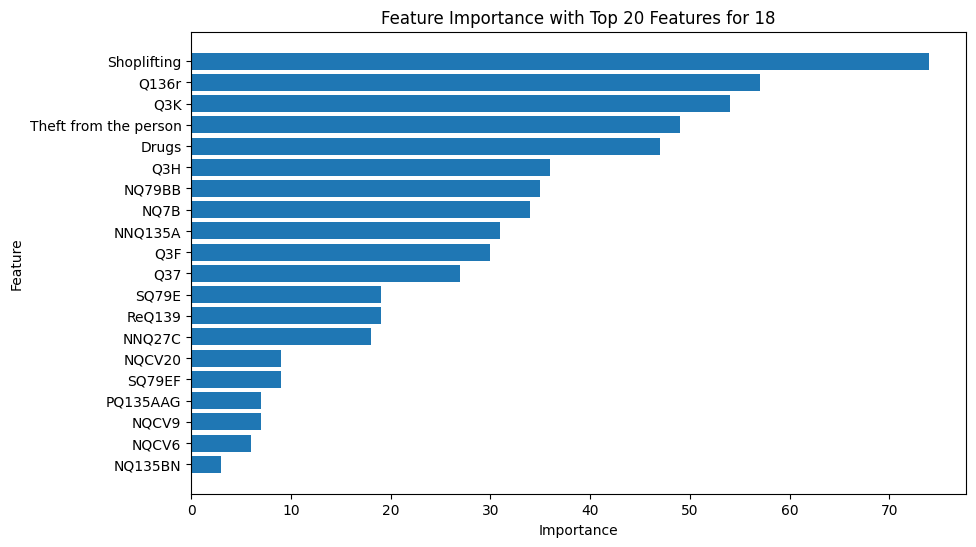

                  Feature  Importance
8             Shoplifting        74.0
7                   Q136r        57.0
2                     Q3K        54.0
10  Theft from the person        49.0
11                  Drugs        47.0
19                    Q3H        36.0
14                 NQ79BB        35.0
18                   NQ7B        34.0
0                 NNQ135A        31.0
9                     Q3F        30.0
5                     Q37        27.0
4                   SQ79E        19.0
1                  ReQ139        19.0
16                 NNQ27C        18.0
6                  NQCV20         9.0
15                 SQ79EF         9.0
13               PQ135AAG         7.0
17                  NQCV9         7.0
3                   NQCV6         6.0
12                NQ135BN         3.0
Processing borough: 28
Splitting data for borough: 28
Converting data to DMatrix format for borough: 28
Training model for borough: 28
[0]	train-rmse:0.66089	test-rmse:0.70542
[10]	train-rmse:0.34441	te

Calculating Permutation Importance for 28: 100%|██████████| 597/597 [05:46<00:00,  1.72it/s]

Top 20 Feature Importance for 28:
XNQ135B: 0.0049
NQ147r: 0.0039
NQ62C: 0.0038
SQ132J: 0.0030
NQ62D: 0.0027
Q194: 0.0027
Q62TG: 0.0023
NQCV28: 0.0020
Shoplifting: 0.0019
XQ128A2A: 0.0017
NQ57AE: 0.0017
Q195B: 0.0016
NQCV25: 0.0014
Q62TJ: 0.0014
NQ135BF: 0.0014
PQ135AAJ: 0.0014
NQ193B: 0.0013
SQ132K: 0.0013
Criminal damage and arson: 0.0013
SQ80C: 0.0012
[0]	train-rmse:0.71468	test-rmse:0.75241
[10]	train-rmse:0.55339	test-rmse:0.69183
[16]	train-rmse:0.52332	test-rmse:0.69640


RMSE on test set with top features for 28: 0.6975940282278058


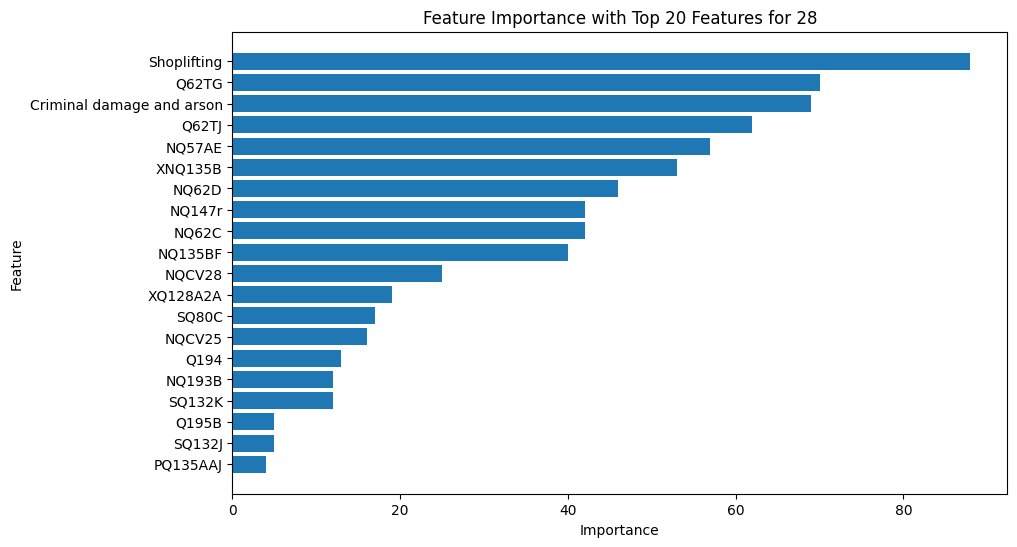

                      Feature  Importance
8                 Shoplifting        88.0
6                       Q62TG        70.0
18  Criminal damage and arson        69.0
13                      Q62TJ        62.0
10                     NQ57AE        57.0
0                     XNQ135B        53.0
4                       NQ62D        46.0
1                      NQ147r        42.0
2                       NQ62C        42.0
14                    NQ135BF        40.0
7                      NQCV28        25.0
9                    XQ128A2A        19.0
19                      SQ80C        17.0
12                     NQCV25        16.0
5                        Q194        13.0
16                     NQ193B        12.0
17                     SQ132K        12.0
11                      Q195B         5.0
3                      SQ132J         5.0
15                   PQ135AAJ         4.0
Processing borough: 5
Splitting data for borough: 5
Converting data to DMatrix format for borough: 5
Training model fo

Calculating Permutation Importance for 5: 100%|██████████| 597/597 [06:06<00:00,  1.63it/s]

Top 20 Feature Importance for 5:
Q62B: 0.0052
Shoplifting: 0.0037
SQ79B: 0.0026
NQ79BC: 0.0023
NQCV25: 0.0023
NQ57AA: 0.0021
BQ90F: 0.0021
NQ135BF: 0.0019
SQ80D: 0.0017
NQ47A: 0.0017
Drugs: 0.0016
NQ62D: 0.0015
NQCV16: 0.0015
NQ193A: 0.0014
ZQ10E: 0.0014
SQ132B: 0.0013
NNQ135A: 0.0013
Q13: 0.0012
NQCV27: 0.0011
Q131: 0.0010
[0]	train-rmse:0.73694	test-rmse:0.76499
[10]	train-rmse:0.57241	test-rmse:0.74998
[18]	train-rmse:0.52433	test-rmse:0.75048


RMSE on test set with top features for 5: 0.7504782923195616


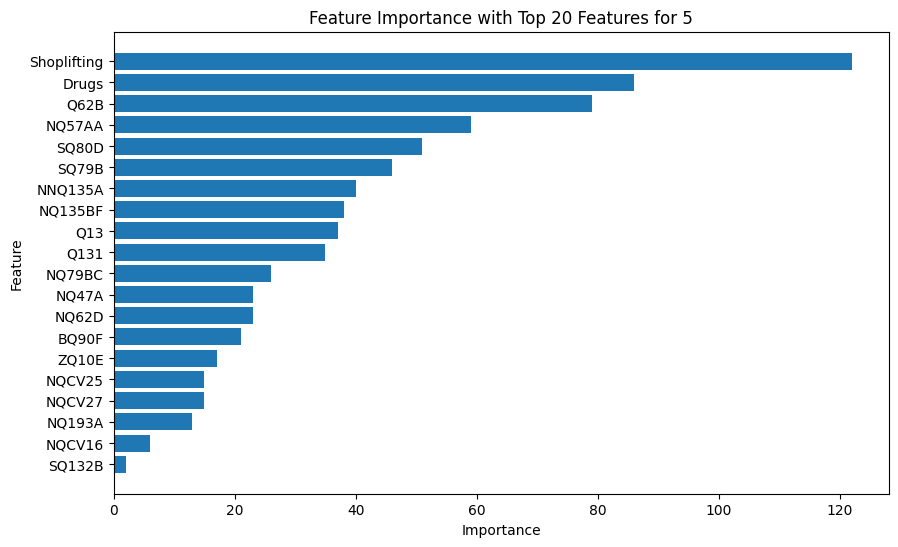

        Feature  Importance
1   Shoplifting       122.0
10        Drugs        86.0
0          Q62B        79.0
5        NQ57AA        59.0
8         SQ80D        51.0
2         SQ79B        46.0
16      NNQ135A        40.0
7       NQ135BF        38.0
17          Q13        37.0
19         Q131        35.0
3        NQ79BC        26.0
9         NQ47A        23.0
11        NQ62D        23.0
6         BQ90F        21.0
14        ZQ10E        17.0
4        NQCV25        15.0
18       NQCV27        15.0
13       NQ193A        13.0
12       NQCV16         6.0
15       SQ132B         2.0
Processing borough: 22
Splitting data for borough: 22
Converting data to DMatrix format for borough: 22
Training model for borough: 22
[0]	train-rmse:0.68297	test-rmse:0.71767
[10]	train-rmse:0.34637	test-rmse:0.60955
[18]	train-rmse:0.29102	test-rmse:0.61547
Making predictions for borough: 22
Calculating RMSE for borough: 22
RMSE for 22: 0.6154709193400142
Calculating permutation importances for borough: 22


Calculating Permutation Importance for 22: 100%|██████████| 597/597 [05:50<00:00,  1.70it/s]

Top 20 Feature Importance for 22:
Q79B: 0.0059
Robbery: 0.0046
Q135BO: 0.0029
NQ62C: 0.0027
NQ79ABB: 0.0020
Q139r: 0.0018
Q3L: 0.0018
Month_Number: 0.0017
Q15: 0.0016
BQ90B: 0.0016
PQ135AAM: 0.0015
NNQ135A: 0.0014
XQ59C: 0.0014
Anti-social behaviour: 0.0013
NQ79ABE: 0.0012
ZQ10A: 0.0011
SQ79B: 0.0010
Q62D: 0.0010
Vehicle crime: 0.0010
NQ135B_newC: 0.0009
[0]	train-rmse:0.74674	test-rmse:0.78031
[10]	train-rmse:0.56896	test-rmse:0.74554
[20]	train-rmse:0.50614	test-rmse:0.75094
[21]	train-rmse:0.50266	test-rmse:0.75161


RMSE on test set with top features for 22: 0.7516142954990044


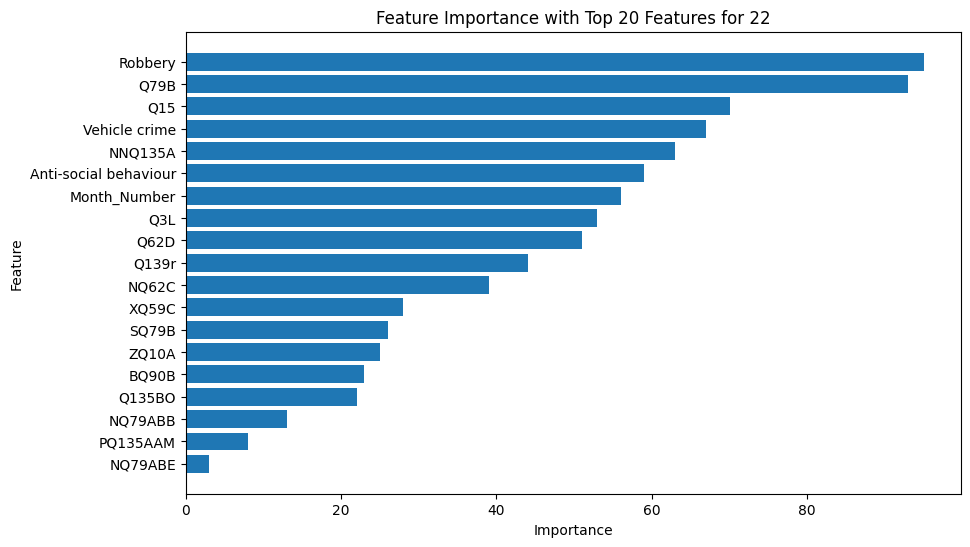

                  Feature  Importance
1                 Robbery        95.0
0                    Q79B        93.0
8                     Q15        70.0
18          Vehicle crime        67.0
11                NNQ135A        63.0
13  Anti-social behaviour        59.0
7            Month_Number        56.0
6                     Q3L        53.0
17                   Q62D        51.0
5                   Q139r        44.0
3                   NQ62C        39.0
12                  XQ59C        28.0
16                  SQ79B        26.0
15                  ZQ10A        25.0
9                   BQ90B        23.0
2                  Q135BO        22.0
4                 NQ79ABB        13.0
10               PQ135AAM         8.0
14                NQ79ABE         3.0
Processing borough: 3
Splitting data for borough: 3
Converting data to DMatrix format for borough: 3
Training model for borough: 3
[0]	train-rmse:0.66557	test-rmse:0.72693
[10]	train-rmse:0.34573	test-rmse:0.59234
[20]	train-rmse:0.28347	te

Calculating Permutation Importance for 3: 100%|██████████| 597/597 [05:59<00:00,  1.66it/s]

Top 20 Feature Importance for 3:
Q139r: 0.0031
NQ147r: 0.0021
Q62TJ: 0.0020
NQCV28: 0.0020
XQ59D: 0.0019
Robbery: 0.0016
Bicycle theft: 0.0016
A120: 0.0016
NQ135A_newAP: 0.0015
Q3L: 0.0015
Q62TG: 0.0014
NQCV27: 0.0014
ReQ136: 0.0013
NQCV4: 0.0012
XQ59C: 0.0012
XQ135r: 0.0011
NQ135A_newAG: 0.0010
SQ79EB: 0.0010
Q79D: 0.0010
Q141: 0.0010
[0]	train-rmse:0.72105	test-rmse:0.77399
[10]	train-rmse:0.52500	test-rmse:0.74993
[15]	train-rmse:0.48868	test-rmse:0.76220


RMSE on test set with top features for 3: 0.7621986685210006


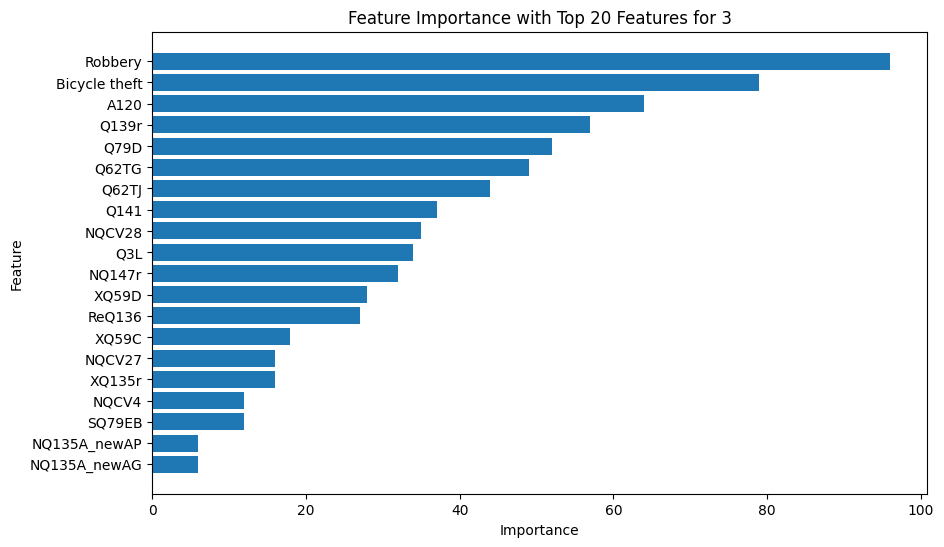

          Feature  Importance
5         Robbery        96.0
6   Bicycle theft        79.0
7            A120        64.0
0           Q139r        57.0
18           Q79D        52.0
10          Q62TG        49.0
2           Q62TJ        44.0
19           Q141        37.0
3          NQCV28        35.0
9             Q3L        34.0
1          NQ147r        32.0
4           XQ59D        28.0
12         ReQ136        27.0
14          XQ59C        18.0
11         NQCV27        16.0
15         XQ135r        16.0
13          NQCV4        12.0
17         SQ79EB        12.0
8    NQ135A_newAP         6.0
16   NQ135A_newAG         6.0
Processing borough: 13
Splitting data for borough: 13
Converting data to DMatrix format for borough: 13
Training model for borough: 13
[0]	train-rmse:0.73519	test-rmse:0.77170
[10]	train-rmse:0.35092	test-rmse:0.60659
[20]	train-rmse:0.27349	test-rmse:0.61504
Making predictions for borough: 13
Calculating RMSE for borough: 13
RMSE for 13: 0.6150411861419453
Calculatin

Calculating Permutation Importance for 13: 100%|██████████| 597/597 [06:51<00:00,  1.45it/s]

Top 20 Feature Importance for 13:
NQCV28: 0.0031
XNQ135B: 0.0031
Criminal damage and arson: 0.0023
Q144: 0.0021
ReXQ135: 0.0019
Q3K: 0.0018
Q195C: 0.0017
Vehicle crime: 0.0015
Violence and sexual offences: 0.0015
PQ135AAJ: 0.0014
Shoplifting: 0.0014
SQ79F: 0.0014
Q10C: 0.0013
parttime_work_number: 0.0013
Q79A: 0.0012
Q10F: 0.0011
XQ59D: 0.0011
Q196C: 0.0010
NQ62B: 0.0009
Q65: 0.0009
[0]	train-rmse:0.83236	test-rmse:0.85142
[10]	train-rmse:0.62786	test-rmse:0.81935
[16]	train-rmse:0.58088	test-rmse:0.83464


RMSE on test set with top features for 13: 0.8346446965802802


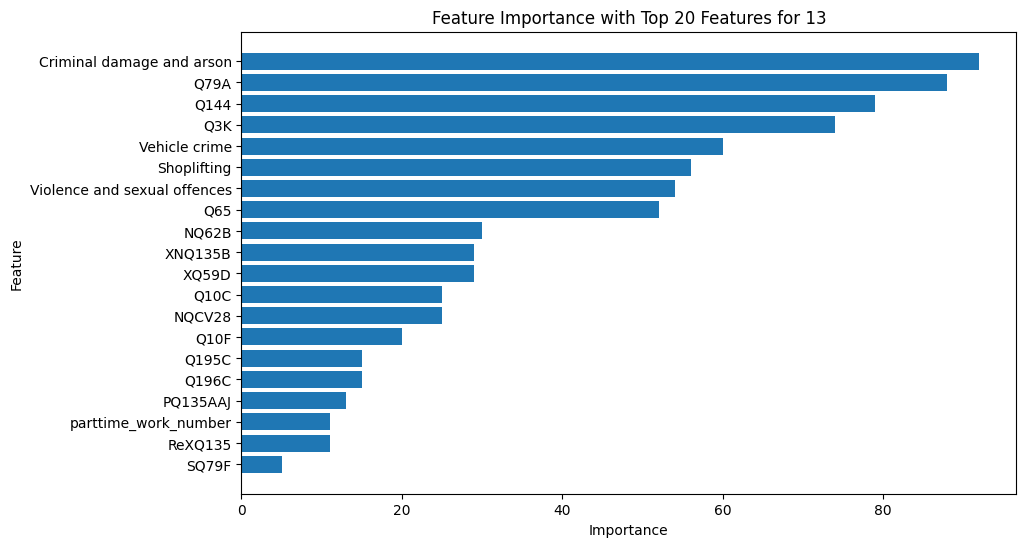

                         Feature  Importance
2      Criminal damage and arson        92.0
14                          Q79A        88.0
3                           Q144        79.0
5                            Q3K        74.0
7                  Vehicle crime        60.0
10                   Shoplifting        56.0
8   Violence and sexual offences        54.0
19                           Q65        52.0
18                         NQ62B        30.0
1                        XNQ135B        29.0
16                         XQ59D        29.0
12                          Q10C        25.0
0                         NQCV28        25.0
15                          Q10F        20.0
6                          Q195C        15.0
17                         Q196C        15.0
9                       PQ135AAJ        13.0
13          parttime_work_number        11.0
4                        ReXQ135        11.0
11                         SQ79F         5.0
Processing borough: 14
Splitting data for borough: 14
C

Calculating Permutation Importance for 14: 100%|██████████| 597/597 [08:51<00:00,  1.12it/s]

Top 20 Feature Importance for 14:
NQCV12: 0.0044
Q3I: 0.0039
Q3C: 0.0035
Q79C: 0.0031
NQ135BF: 0.0025
Other crime: 0.0024
Burglary: 0.0023
NQ135BI: 0.0022
NQ57AC: 0.0021
NQ135BC: 0.0019
Q62TJ: 0.0018
Q59: 0.0017
Q62C: 0.0017
ZQ10F: 0.0016
NQ135BE: 0.0014
NQ79BI: 0.0013
Q79A: 0.0012
SQ80D: 0.0012
Q1: 0.0011
Q79H: 0.0011
[0]	train-rmse:0.71504	test-rmse:0.80228
[10]	train-rmse:0.48901	test-rmse:0.73718
[15]	train-rmse:0.45371	test-rmse:0.74150


RMSE on test set with top features for 14: 0.7431698315166405


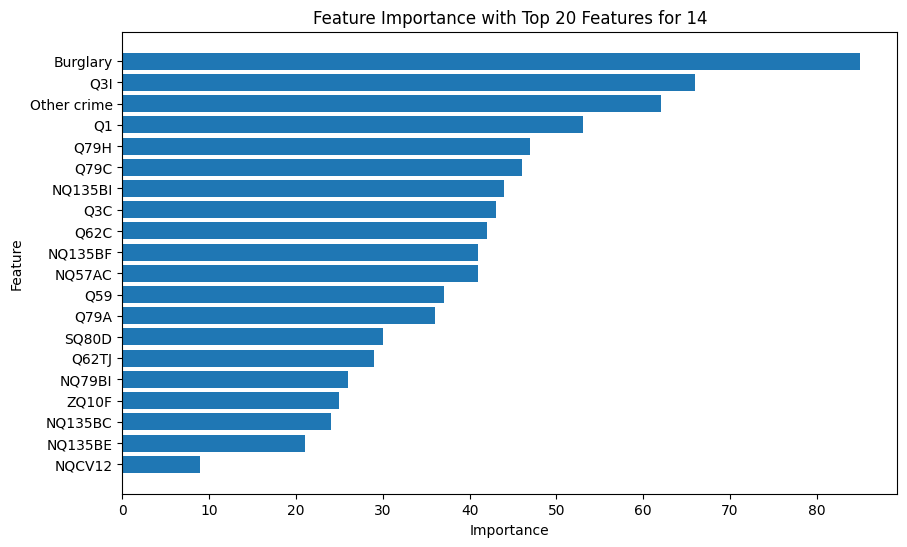

        Feature  Importance
6      Burglary        85.0
1           Q3I        66.0
5   Other crime        62.0
18           Q1        53.0
19         Q79H        47.0
3          Q79C        46.0
7       NQ135BI        44.0
2           Q3C        43.0
12         Q62C        42.0
4       NQ135BF        41.0
8        NQ57AC        41.0
11          Q59        37.0
16         Q79A        36.0
17        SQ80D        30.0
10        Q62TJ        29.0
15       NQ79BI        26.0
13        ZQ10F        25.0
9       NQ135BC        24.0
14      NQ135BE        21.0
0        NQCV12         9.0
Processing borough: 9
Splitting data for borough: 9
Converting data to DMatrix format for borough: 9
Training model for borough: 9
[0]	train-rmse:0.73880	test-rmse:0.78065
[10]	train-rmse:0.36982	test-rmse:0.63278
[20]	train-rmse:0.28492	test-rmse:0.63307
[27]	train-rmse:0.24608	test-rmse:0.63505
Making predictions for borough: 9
Calculating RMSE for borough: 9
RMSE for 9: 0.6350460936942562
Calculating permu

Calculating Permutation Importance for 9: 100%|██████████| 597/597 [08:52<00:00,  1.12it/s]

Top 20 Feature Importance for 9:
A121: 0.0041
ReQ136: 0.0036
Anti-social behaviour: 0.0036
Q79F: 0.0028
NQCV14: 0.0026
NQ80H: 0.0024
Bicycle theft: 0.0022
NNQ27E: 0.0020
Q196C: 0.0020
SQ79EG: 0.0019
Drugs: 0.0017
Q79I: 0.0016
Q62E: 0.0015
Violence and sexual offences: 0.0015
XQ106D: 0.0015
NQCV2: 0.0013
XQ122B: 0.0013
Public order: 0.0012
Q62TJ: 0.0011
Q59: 0.0011
[0]	train-rmse:0.81163	test-rmse:0.85703
[10]	train-rmse:0.59766	test-rmse:0.84476
[12]	train-rmse:0.58199	test-rmse:0.84815


RMSE on test set with top features for 9: 0.8516971517100523


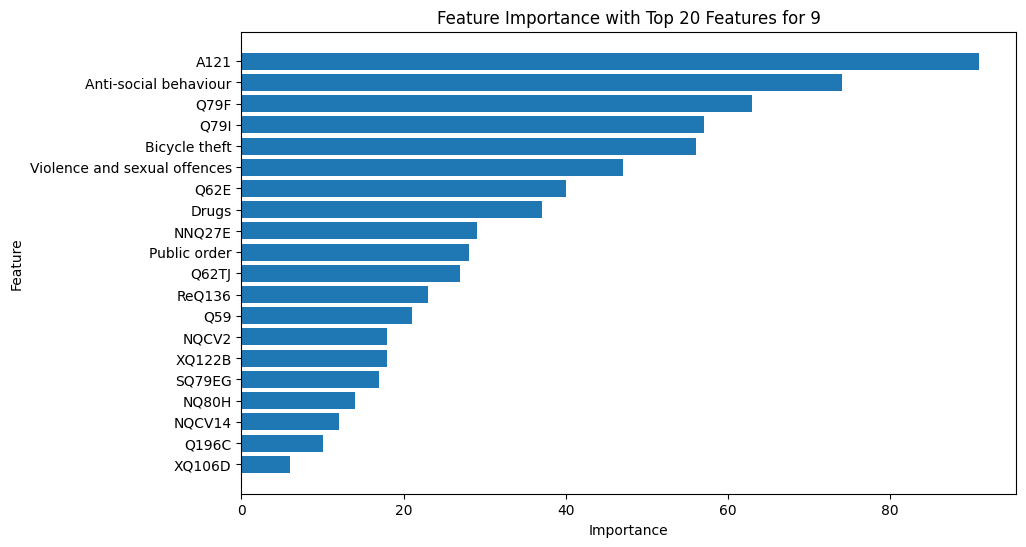

                         Feature  Importance
0                           A121        91.0
2          Anti-social behaviour        74.0
3                           Q79F        63.0
11                          Q79I        57.0
6                  Bicycle theft        56.0
13  Violence and sexual offences        47.0
12                          Q62E        40.0
10                         Drugs        37.0
7                         NNQ27E        29.0
17                  Public order        28.0
18                         Q62TJ        27.0
1                         ReQ136        23.0
19                           Q59        21.0
15                         NQCV2        18.0
16                        XQ122B        18.0
9                         SQ79EG        17.0
5                          NQ80H        14.0
4                         NQCV14        12.0
8                          Q196C        10.0
14                        XQ106D         6.0
Processing borough: 7
Splitting data for borough: 7
Con

Calculating Permutation Importance for 7: 100%|██████████| 597/597 [08:51<00:00,  1.12it/s]

Top 20 Feature Importance for 7:
Q62TI: 0.0040
Q3G: 0.0038
NQCV14: 0.0030
NQCV2: 0.0026
Q79A: 0.0025
Shoplifting: 0.0024
NQCV4: 0.0022
Bicycle theft: 0.0017
Mixed/ Other: 0.0017
Q136r: 0.0015
SQ80F: 0.0014
Q3H: 0.0013
Public order: 0.0013
Q14C: 0.0012
NQ135BDB: 0.0012
Q58: 0.0012
NQ135BE: 0.0010
NQCV8: 0.0010
NQCV25: 0.0010
ZQ10F: 0.0008
[0]	train-rmse:0.76261	test-rmse:0.84293
[10]	train-rmse:0.55364	test-rmse:0.81620
[13]	train-rmse:0.52947	test-rmse:0.81991


RMSE on test set with top features for 7: 0.8226967586374165


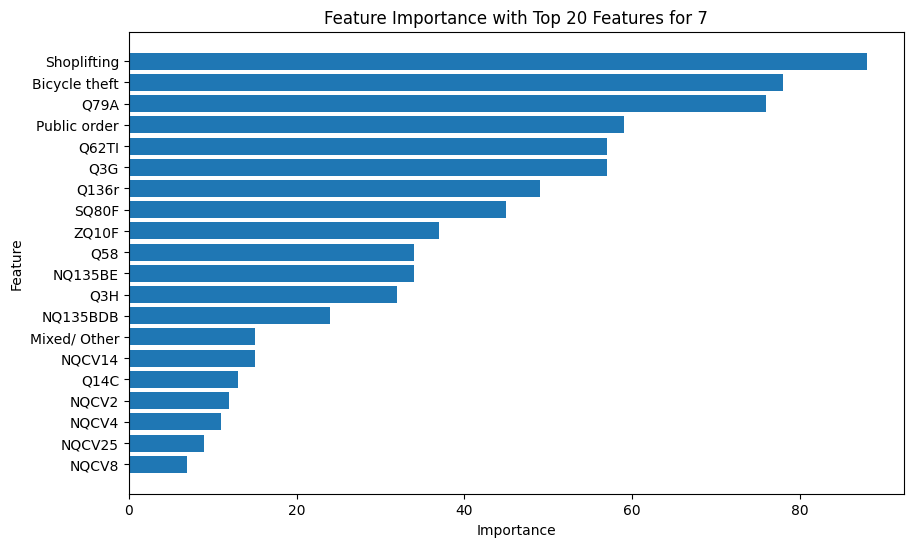

          Feature  Importance
5     Shoplifting        88.0
7   Bicycle theft        78.0
4            Q79A        76.0
12   Public order        59.0
0           Q62TI        57.0
1             Q3G        57.0
9           Q136r        49.0
10          SQ80F        45.0
19          ZQ10F        37.0
15            Q58        34.0
16        NQ135BE        34.0
11            Q3H        32.0
14       NQ135BDB        24.0
8    Mixed/ Other        15.0
2          NQCV14        15.0
13           Q14C        13.0
3           NQCV2        12.0
6           NQCV4        11.0
18         NQCV25         9.0
17          NQCV8         7.0
Processing borough: 24
Splitting data for borough: 24
Converting data to DMatrix format for borough: 24
Training model for borough: 24
[0]	train-rmse:0.73688	test-rmse:0.81893
[10]	train-rmse:0.35198	test-rmse:0.65797
[20]	train-rmse:0.27941	test-rmse:0.65715
[23]	train-rmse:0.26819	test-rmse:0.65895
Making predictions for borough: 24
Calculating RMSE for borough: 24


Calculating Permutation Importance for 24: 100%|██████████| 597/597 [08:48<00:00,  1.13it/s]

Top 20 Feature Importance for 24:
Shoplifting: 0.0030
ZQ10I: 0.0027
Public order: 0.0027
Q79J: 0.0025
Q62TG: 0.0023
Q79F: 0.0022
NQ79D: 0.0021
NQCV22: 0.0020
ReNQ147: 0.0020
SQ80F: 0.0019
Q195B: 0.0018
Q3C: 0.0017
NQ135BE: 0.0017
ZQ10A: 0.0017
XQ21B: 0.0017
Vehicle crime: 0.0016
NQ197: 0.0015
NQ7B: 0.0014
Q62TJ: 0.0014
NQ2H: 0.0013
[0]	train-rmse:0.78950	test-rmse:0.86421
[10]	train-rmse:0.55918	test-rmse:0.79931
[15]	train-rmse:0.52993	test-rmse:0.80033


RMSE on test set with top features for 24: 0.8003298014400912


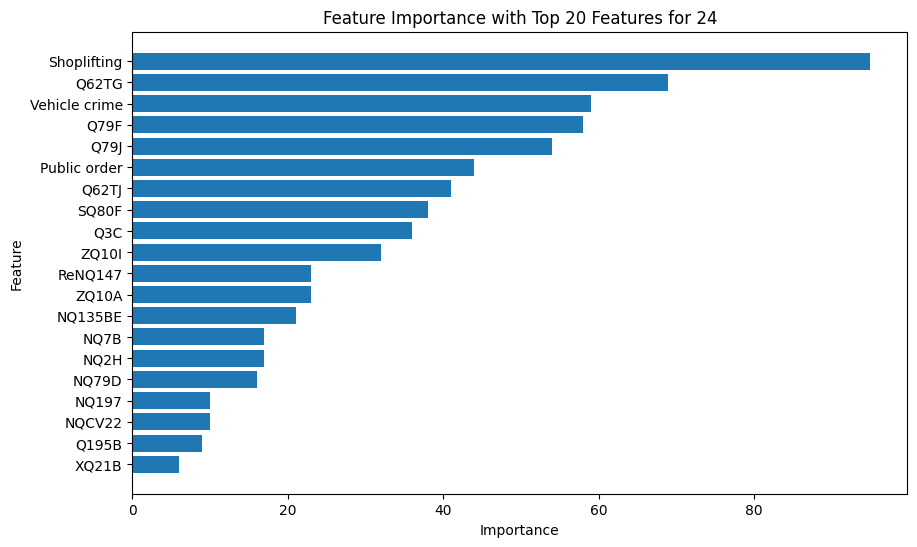

          Feature  Importance
0     Shoplifting        95.0
4           Q62TG        69.0
15  Vehicle crime        59.0
5            Q79F        58.0
3            Q79J        54.0
2    Public order        44.0
18          Q62TJ        41.0
9           SQ80F        38.0
11            Q3C        36.0
1           ZQ10I        32.0
8         ReNQ147        23.0
13          ZQ10A        23.0
12        NQ135BE        21.0
17           NQ7B        17.0
19           NQ2H        17.0
6           NQ79D        16.0
16          NQ197        10.0
7          NQCV22        10.0
10          Q195B         9.0
14          XQ21B         6.0
Processing borough: 1
Splitting data for borough: 1
Converting data to DMatrix format for borough: 1
Training model for borough: 1
[0]	train-rmse:0.72276	test-rmse:0.77421
[10]	train-rmse:0.35188	test-rmse:0.63209
[20]	train-rmse:0.28158	test-rmse:0.63348
[21]	train-rmse:0.27560	test-rmse:0.63354
Making predictions for borough: 1
Calculating RMSE for borough: 1
RMSE f

Calculating Permutation Importance for 1: 100%|██████████| 597/597 [08:50<00:00,  1.12it/s]

Top 20 Feature Importance for 1:
Q79J: 0.0033
ZNQ119: 0.0028
Q3F: 0.0028
NQ7B: 0.0024
NQ135BDB: 0.0021
ZNQ10BD: 0.0018
Q10B: 0.0014
BQ90F: 0.0013
NQ193B: 0.0013
Shoplifting: 0.0012
Q196B: 0.0012
Possession of weapons: 0.0012
NQ135BI: 0.0012
SQ80E: 0.0011
Q3H: 0.0011
Q79H: 0.0010
XQ3A: 0.0009
XQ135r: 0.0009
XQ128A2D: 0.0008
SQ79EG: 0.0008
[0]	train-rmse:0.80558	test-rmse:0.85414
[10]	train-rmse:0.59018	test-rmse:0.83138
[12]	train-rmse:0.58059	test-rmse:0.83221


RMSE on test set with top features for 1: 0.8362506895620809


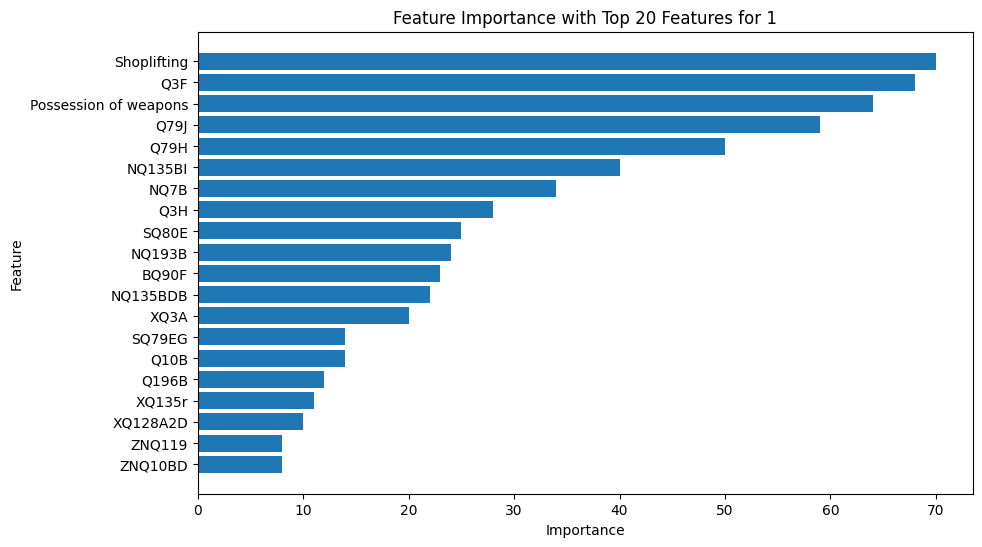

                  Feature  Importance
9             Shoplifting        70.0
2                     Q3F        68.0
11  Possession of weapons        64.0
0                    Q79J        59.0
15                   Q79H        50.0
12                NQ135BI        40.0
3                    NQ7B        34.0
14                    Q3H        28.0
13                  SQ80E        25.0
8                  NQ193B        24.0
7                   BQ90F        23.0
4                NQ135BDB        22.0
16                   XQ3A        20.0
19                 SQ79EG        14.0
6                    Q10B        14.0
10                  Q196B        12.0
17                 XQ135r        11.0
18               XQ128A2D        10.0
1                  ZNQ119         8.0
5                 ZNQ10BD         8.0
Processing borough: 15
Splitting data for borough: 15
Converting data to DMatrix format for borough: 15
Training model for borough: 15
[0]	train-rmse:0.71717	test-rmse:0.81176
[10]	train-rmse:0.35875	te

Calculating Permutation Importance for 15: 100%|██████████| 597/597 [08:51<00:00,  1.12it/s]

Top 20 Feature Importance for 15:
Vehicle crime: 0.0064
SQ80D: 0.0049
NQ79D: 0.0045
Theft from the person: 0.0038
SQ79EA: 0.0034
Other crime: 0.0028
Shoplifting: 0.0027
Q62TI: 0.0020
SQ79C: 0.0018
Anti-social behaviour: 0.0016
Q3C: 0.0015
XQ122B: 0.0015
NQCV11: 0.0015
Q62TJ: 0.0014
Q62C: 0.0013
Q59: 0.0013
Q132AM: 0.0011
SQ132G: 0.0010
NQ135A_newAB: 0.0010
SQ132K: 0.0009
[0]	train-rmse:0.77870	test-rmse:0.86574
[10]	train-rmse:0.56181	test-rmse:0.81238
[18]	train-rmse:0.52345	test-rmse:0.81772


RMSE on test set with top features for 15: 0.8173795014925048


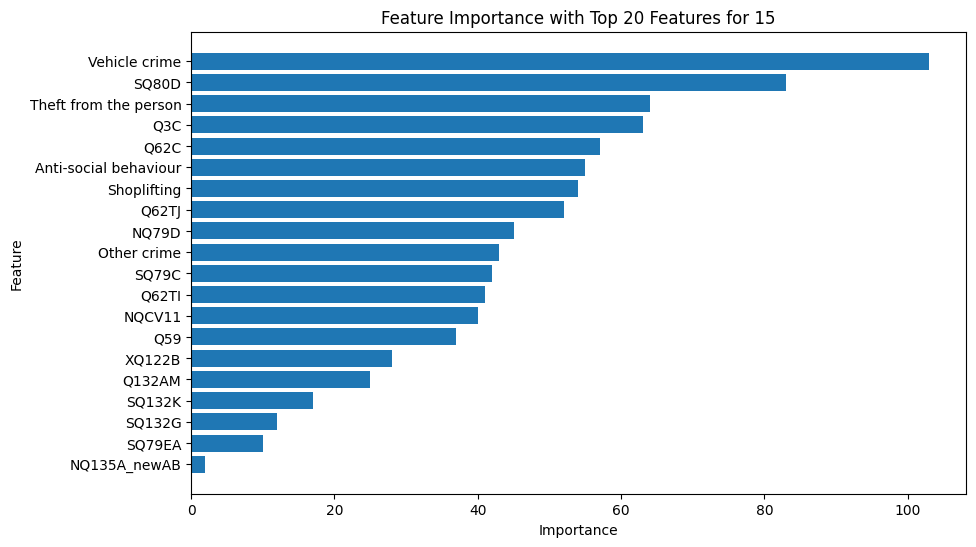

                  Feature  Importance
0           Vehicle crime       103.0
1                   SQ80D        83.0
3   Theft from the person        64.0
10                    Q3C        63.0
14                   Q62C        57.0
9   Anti-social behaviour        55.0
6             Shoplifting        54.0
13                  Q62TJ        52.0
2                   NQ79D        45.0
5             Other crime        43.0
8                   SQ79C        42.0
7                   Q62TI        41.0
12                 NQCV11        40.0
15                    Q59        37.0
11                 XQ122B        28.0
16                 Q132AM        25.0
19                 SQ132K        17.0
17                 SQ132G        12.0
4                  SQ79EA        10.0
18           NQ135A_newAB         2.0
Processing borough: 25
Splitting data for borough: 25
Converting data to DMatrix format for borough: 25
Training model for borough: 25
[0]	train-rmse:0.73454	test-rmse:0.73687
[10]	train-rmse:0.36544	te

Calculating Permutation Importance for 25: 100%|██████████| 597/597 [08:47<00:00,  1.13it/s]

Top 20 Feature Importance for 25:
Q62TJ: 0.0045
Q54A: 0.0037
Q15: 0.0035
Q13: 0.0034
Q14B: 0.0033
Criminal damage and arson: 0.0027
ReQ139: 0.0026
Q196C: 0.0024
NNQ135A: 0.0020
Theft from the person: 0.0019
NQ46A: 0.0019
Q195A: 0.0019
Shoplifting: 0.0017
PQ135AP: 0.0017
PQ135AA: 0.0015
XQ59D: 0.0015
ReNQ147: 0.0015
ZNQ119: 0.0013
ReQ136: 0.0013
NQ135BE: 0.0012
[0]	train-rmse:0.81798	test-rmse:0.81648
[10]	train-rmse:0.61201	test-rmse:0.80438
[16]	train-rmse:0.57456	test-rmse:0.81736


RMSE on test set with top features for 25: 0.817358252553222


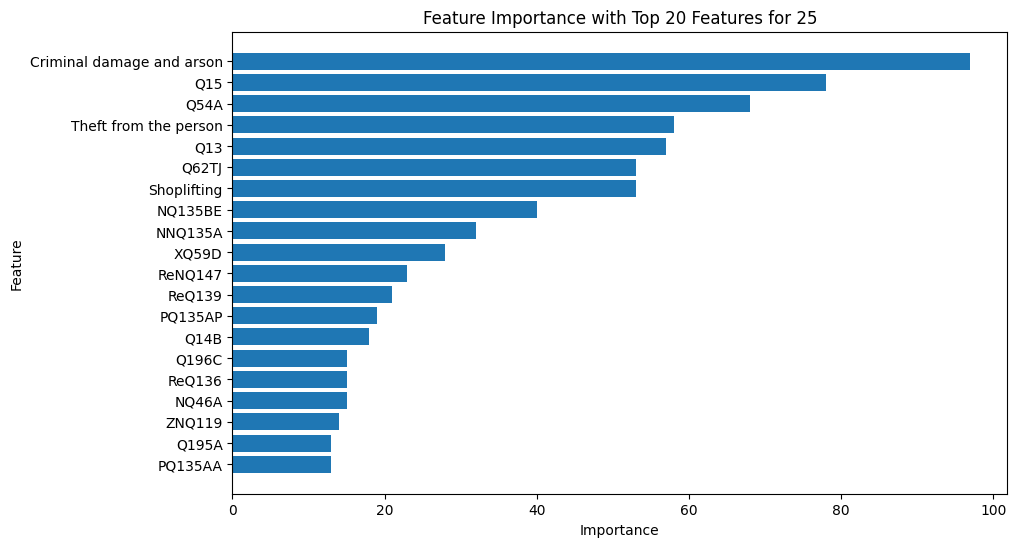

                      Feature  Importance
5   Criminal damage and arson        97.0
2                         Q15        78.0
1                        Q54A        68.0
9       Theft from the person        58.0
3                         Q13        57.0
0                       Q62TJ        53.0
12                Shoplifting        53.0
19                    NQ135BE        40.0
8                     NNQ135A        32.0
15                      XQ59D        28.0
16                    ReNQ147        23.0
6                      ReQ139        21.0
13                    PQ135AP        19.0
4                        Q14B        18.0
7                       Q196C        15.0
18                     ReQ136        15.0
10                      NQ46A        15.0
17                     ZNQ119        14.0
11                      Q195A        13.0
14                    PQ135AA        13.0
Processing borough: 27
Splitting data for borough: 27
Converting data to DMatrix format for borough: 27
Training model

Calculating Permutation Importance for 27: 100%|██████████| 597/597 [08:42<00:00,  1.14it/s]

Top 20 Feature Importance for 27:
Q3J: 0.0035
NQCV12: 0.0026
Q79C: 0.0024
Burglary: 0.0023
Q62C: 0.0022
Vehicle crime: 0.0021
ReQ139: 0.0020
NQ57AE: 0.0019
XQ128A2A: 0.0019
NQCV20: 0.0015
XQ8: 0.0015
Q3C: 0.0014
IMDQuartile: 0.0013
Other crime: 0.0013
Q141: 0.0012
NQ136CB: 0.0012
Q3K: 0.0011
ReQ136: 0.0010
A121: 0.0010
ZQ10C: 0.0010
[0]	train-rmse:0.73433	test-rmse:0.79133
[10]	train-rmse:0.52421	test-rmse:0.77721
[13]	train-rmse:0.50262	test-rmse:0.77790


RMSE on test set with top features for 27: 0.7809472416100022


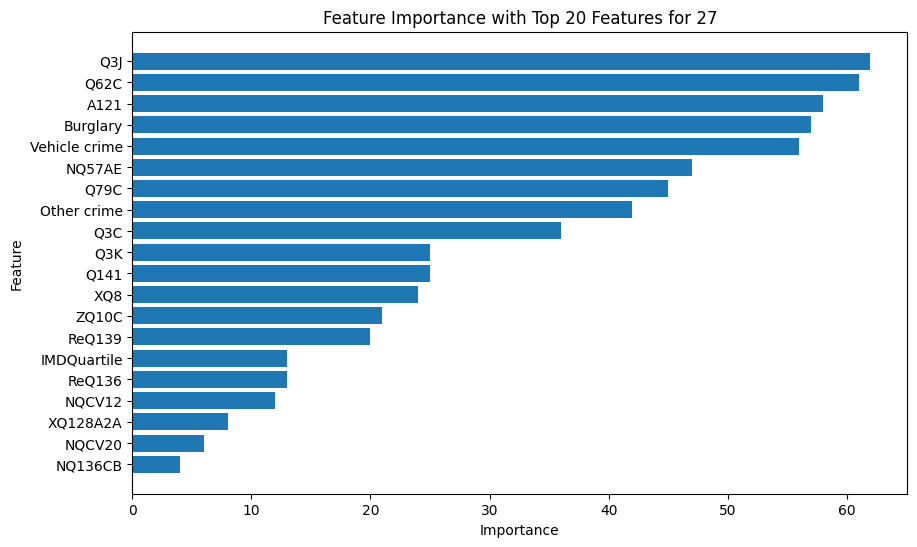

          Feature  Importance
0             Q3J        62.0
4            Q62C        61.0
18           A121        58.0
3        Burglary        57.0
5   Vehicle crime        56.0
7          NQ57AE        47.0
2            Q79C        45.0
13    Other crime        42.0
11            Q3C        36.0
16            Q3K        25.0
14           Q141        25.0
10            XQ8        24.0
19          ZQ10C        21.0
6          ReQ139        20.0
12    IMDQuartile        13.0
17         ReQ136        13.0
1          NQCV12        12.0
8        XQ128A2A         8.0
9          NQCV20         6.0
15        NQ136CB         4.0
Processing borough: 21
Splitting data for borough: 21
Converting data to DMatrix format for borough: 21
Training model for borough: 21
[0]	train-rmse:0.66017	test-rmse:0.73923
[10]	train-rmse:0.32507	test-rmse:0.62592
[20]	train-rmse:0.26269	test-rmse:0.62694
[21]	train-rmse:0.26008	test-rmse:0.62550
Making predictions for borough: 21
Calculating RMSE for borough: 21


Calculating Permutation Importance for 21: 100%|██████████| 597/597 [08:41<00:00,  1.14it/s]

Top 20 Feature Importance for 21:
ReNQ147: 0.0044
Q21: 0.0038
NQCV26: 0.0032
Q62E: 0.0019
NQCV12: 0.0015
NQ135BDE: 0.0015
Q3I: 0.0014
NQCV6: 0.0014
ZQ10D: 0.0013
XQ59C: 0.0013
NQ43: 0.0012
NQ45BA: 0.0012
NNQ27C: 0.0011
XQ122B: 0.0011
NQ135BH: 0.0010
ReQ136: 0.0010
NQ57AB: 0.0010
Q54A: 0.0009
Vehicle crime: 0.0009
Q79G: 0.0009
[0]	train-rmse:0.72905	test-rmse:0.77891
[10]	train-rmse:0.53761	test-rmse:0.73136
[16]	train-rmse:0.49589	test-rmse:0.73596


RMSE on test set with top features for 21: 0.7359552532476202


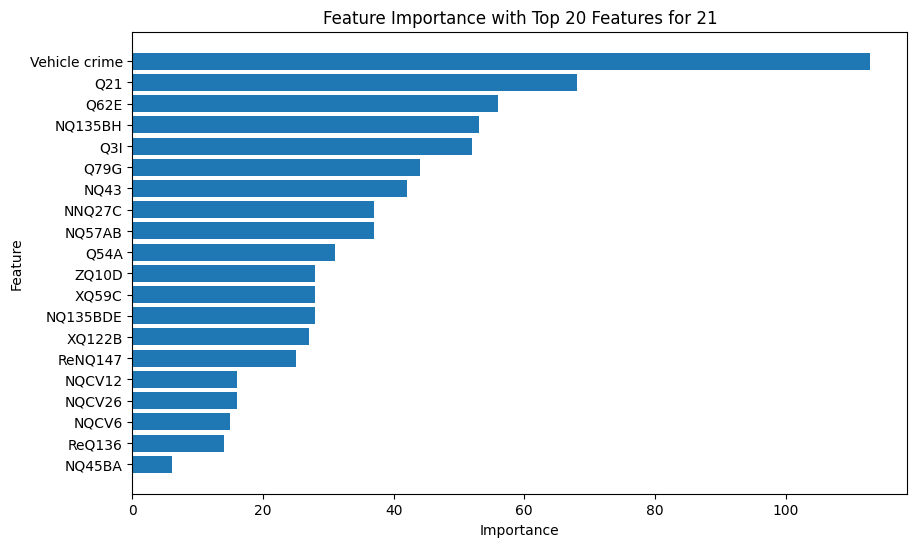

          Feature  Importance
18  Vehicle crime       113.0
1             Q21        68.0
3            Q62E        56.0
14        NQ135BH        53.0
6             Q3I        52.0
19           Q79G        44.0
10           NQ43        42.0
12         NNQ27C        37.0
16         NQ57AB        37.0
17           Q54A        31.0
8           ZQ10D        28.0
9           XQ59C        28.0
5        NQ135BDE        28.0
13         XQ122B        27.0
0         ReNQ147        25.0
4          NQCV12        16.0
2          NQCV26        16.0
7           NQCV6        15.0
15         ReQ136        14.0
11         NQ45BA         6.0
Processing borough: 17
Splitting data for borough: 17
Converting data to DMatrix format for borough: 17
Training model for borough: 17
[0]	train-rmse:0.71382	test-rmse:0.75322
[10]	train-rmse:0.36250	test-rmse:0.60335
[19]	train-rmse:0.29087	test-rmse:0.60799
Making predictions for borough: 17
Calculating RMSE for borough: 17
RMSE for 17: 0.6083410915114519
Calculatin

Calculating Permutation Importance for 17: 100%|██████████| 597/597 [08:45<00:00,  1.14it/s]

Top 20 Feature Importance for 17:
Q3C: 0.0042
Q133: 0.0039
NQ62C: 0.0034
XQ21B: 0.0033
Q126DB: 0.0026
Violence and sexual offences: 0.0026
SQ79EO: 0.0025
Public order: 0.0024
NQ79D: 0.0021
XQ3A: 0.0018
Robbery: 0.0018
Other crime: 0.0017
Q3G: 0.0017
NQCV2: 0.0016
White: 0.0015
Q3H: 0.0013
NQ7B: 0.0013
NQCV1: 0.0013
Q14C: 0.0013
Q3I: 0.0012
[0]	train-rmse:0.79543	test-rmse:0.83164
[10]	train-rmse:0.63532	test-rmse:0.83516
[14]	train-rmse:0.61266	test-rmse:0.84675


RMSE on test set with top features for 17: 0.8467506480502082


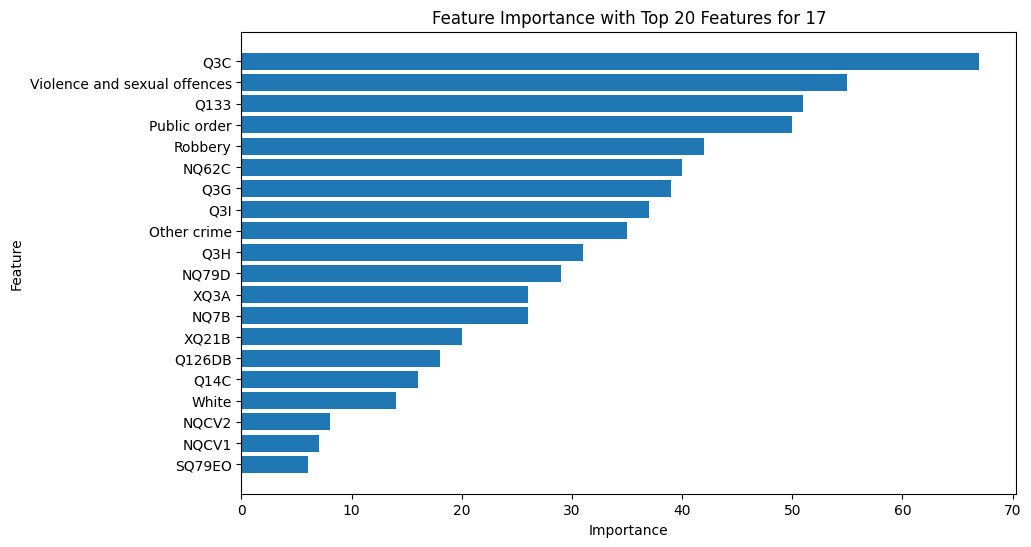

                         Feature  Importance
0                            Q3C        67.0
5   Violence and sexual offences        55.0
1                           Q133        51.0
7                   Public order        50.0
10                       Robbery        42.0
2                          NQ62C        40.0
12                           Q3G        39.0
19                           Q3I        37.0
11                   Other crime        35.0
15                           Q3H        31.0
8                          NQ79D        29.0
9                           XQ3A        26.0
16                          NQ7B        26.0
3                          XQ21B        20.0
4                         Q126DB        18.0
18                          Q14C        16.0
14                         White        14.0
13                         NQCV2         8.0
17                         NQCV1         7.0
6                         SQ79EO         6.0
Processing borough: 10
Splitting data for borough: 10
C

Calculating Permutation Importance for 10: 100%|██████████| 597/597 [08:45<00:00,  1.14it/s]

Top 20 Feature Importance for 10:
NQ57AD: 0.0056
NQ135BD: 0.0051
Q136r: 0.0043
Q58: 0.0030
Criminal damage and arson: 0.0029
ReQ136: 0.0024
SQ132GG: 0.0022
Q3C: 0.0020
Q144: 0.0020
SQ79EE: 0.0019
NNQ27E: 0.0017
Q62C: 0.0016
Other crime: 0.0015
NQ43AD: 0.0014
Q21: 0.0013
Q79A: 0.0013
Black: 0.0013
Q3L: 0.0012
ZQ10B: 0.0012
ZQ10F: 0.0011
[0]	train-rmse:0.74862	test-rmse:0.74402
[10]	train-rmse:0.52447	test-rmse:0.66496
[20]	train-rmse:0.45539	test-rmse:0.66205
[30]	train-rmse:0.40353	test-rmse:0.66496
[36]	train-rmse:0.37647	test-rmse:0.66733


RMSE on test set with top features for 10: 0.6671657525572074


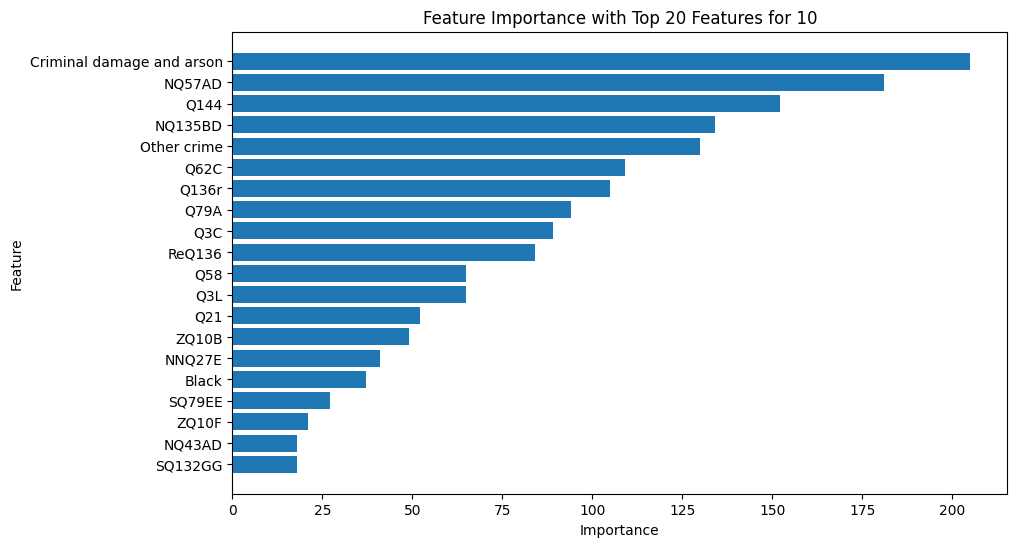

                      Feature  Importance
4   Criminal damage and arson       205.0
0                      NQ57AD       181.0
8                        Q144       152.0
1                     NQ135BD       134.0
12                Other crime       130.0
11                       Q62C       109.0
2                       Q136r       105.0
15                       Q79A        94.0
7                         Q3C        89.0
5                      ReQ136        84.0
3                         Q58        65.0
17                        Q3L        65.0
14                        Q21        52.0
18                      ZQ10B        49.0
10                     NNQ27E        41.0
16                      Black        37.0
9                      SQ79EE        27.0
19                      ZQ10F        21.0
13                     NQ43AD        18.0
6                     SQ132GG        18.0
Processing borough: 20
Splitting data for borough: 20
Converting data to DMatrix format for borough: 20
Training model

Calculating Permutation Importance for 20: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 20:
Q21: 0.0052
Q79G: 0.0038
NQ57AC: 0.0035
XQ59B: 0.0025
XQ59D: 0.0020
XQ128A2B: 0.0019
Q79C: 0.0019
NQCV27: 0.0017
NQ135BF: 0.0016
NQ135BC: 0.0016
Q136r: 0.0016
Violence and sexual offences: 0.0015
NNQ135A: 0.0014
Other theft: 0.0013
Q3F: 0.0013
ZQ10D: 0.0013
SQ79ED: 0.0013
Q54A: 0.0012
XQ119A: 0.0012
Q144: 0.0012
[0]	train-rmse:0.68231	test-rmse:0.69418
[10]	train-rmse:0.51432	test-rmse:0.66872
[15]	train-rmse:0.48008	test-rmse:0.67689


RMSE on test set with top features for 20: 0.6768917709412304


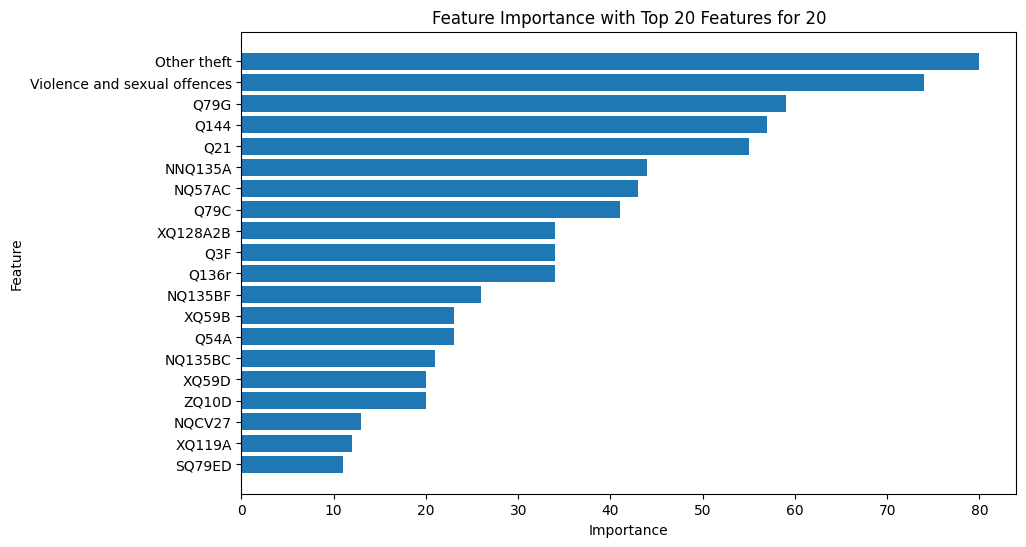

                         Feature  Importance
13                   Other theft        80.0
11  Violence and sexual offences        74.0
1                           Q79G        59.0
19                          Q144        57.0
0                            Q21        55.0
12                       NNQ135A        44.0
2                         NQ57AC        43.0
6                           Q79C        41.0
5                       XQ128A2B        34.0
14                           Q3F        34.0
10                         Q136r        34.0
8                        NQ135BF        26.0
3                          XQ59B        23.0
17                          Q54A        23.0
9                        NQ135BC        21.0
4                          XQ59D        20.0
15                         ZQ10D        20.0
7                         NQCV27        13.0
18                        XQ119A        12.0
16                        SQ79ED        11.0
Processing borough: 23
Splitting data for borough: 23
C

Calculating Permutation Importance for 23: 100%|██████████| 597/597 [08:45<00:00,  1.14it/s]

Top 20 Feature Importance for 23:
SQ79EA: 0.0039
NQ193A: 0.0036
Q136r: 0.0022
Q21: 0.0022
Bicycle theft: 0.0020
NQ135BH: 0.0019
SQ79EE: 0.0019
Vehicle crime: 0.0019
NNQ135A: 0.0018
ReQ139: 0.0017
Q144: 0.0017
Q54A: 0.0017
NQCV2: 0.0015
NQ135BD: 0.0015
NQ147r: 0.0014
NQ135BDE: 0.0014
Q65: 0.0014
Q79I: 0.0014
NQ62C: 0.0013
NQ197: 0.0013
[0]	train-rmse:0.69996	test-rmse:0.73812
[10]	train-rmse:0.51519	test-rmse:0.69165
[15]	train-rmse:0.48542	test-rmse:0.69988


RMSE on test set with top features for 23: 0.703441277270541


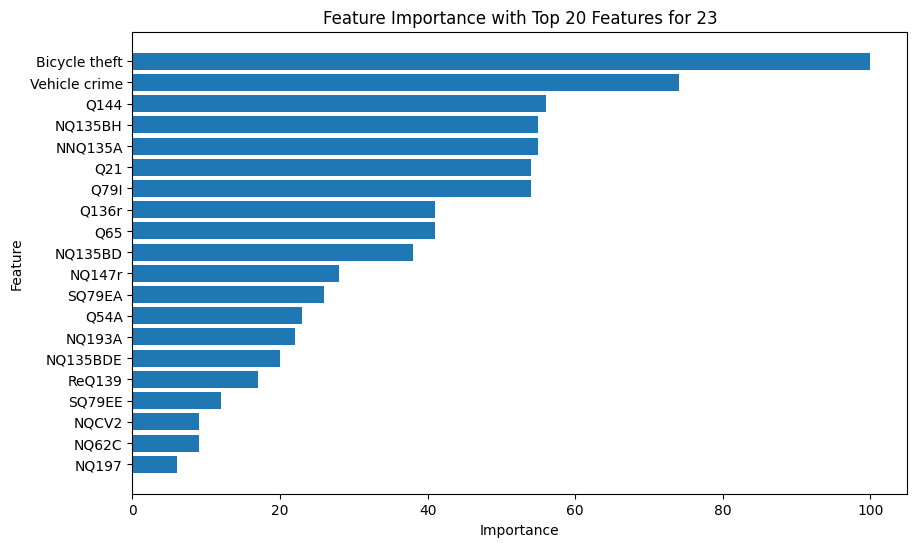

          Feature  Importance
4   Bicycle theft       100.0
7   Vehicle crime        74.0
10           Q144        56.0
5         NQ135BH        55.0
8         NNQ135A        55.0
3             Q21        54.0
17           Q79I        54.0
2           Q136r        41.0
16            Q65        41.0
13        NQ135BD        38.0
14         NQ147r        28.0
0          SQ79EA        26.0
11           Q54A        23.0
1          NQ193A        22.0
15       NQ135BDE        20.0
9          ReQ139        17.0
6          SQ79EE        12.0
12          NQCV2         9.0
18          NQ62C         9.0
19          NQ197         6.0
Processing borough: 2
Splitting data for borough: 2
Converting data to DMatrix format for borough: 2
Training model for borough: 2
[0]	train-rmse:0.65750	test-rmse:0.73581
[10]	train-rmse:0.33562	test-rmse:0.59477
[20]	train-rmse:0.26649	test-rmse:0.58839
[25]	train-rmse:0.24345	test-rmse:0.59225
Making predictions for borough: 2
Calculating RMSE for borough: 2
RMSE f

Calculating Permutation Importance for 2: 100%|██████████| 597/597 [08:45<00:00,  1.14it/s]

Top 20 Feature Importance for 2:
Q3G: 0.0034
XBQ90A: 0.0027
Theft from the person: 0.0026
XQ59D: 0.0023
Possession of weapons: 0.0020
Q144: 0.0019
NQ135BD: 0.0015
NQ47A: 0.0014
Q62TJ: 0.0012
BQ90F: 0.0012
Q3F: 0.0012
Q79G: 0.0011
A120: 0.0011
NQ135A_newAY: 0.0009
Mixed/ Other: 0.0009
Q136r: 0.0009
Q194: 0.0009
Violence and sexual offences: 0.0008
XNQ135B: 0.0008
NQ62B: 0.0008
[0]	train-rmse:0.71893	test-rmse:0.80637
[10]	train-rmse:0.51985	test-rmse:0.73953
[20]	train-rmse:0.46051	test-rmse:0.74398


RMSE on test set with top features for 2: 0.7463529245606063


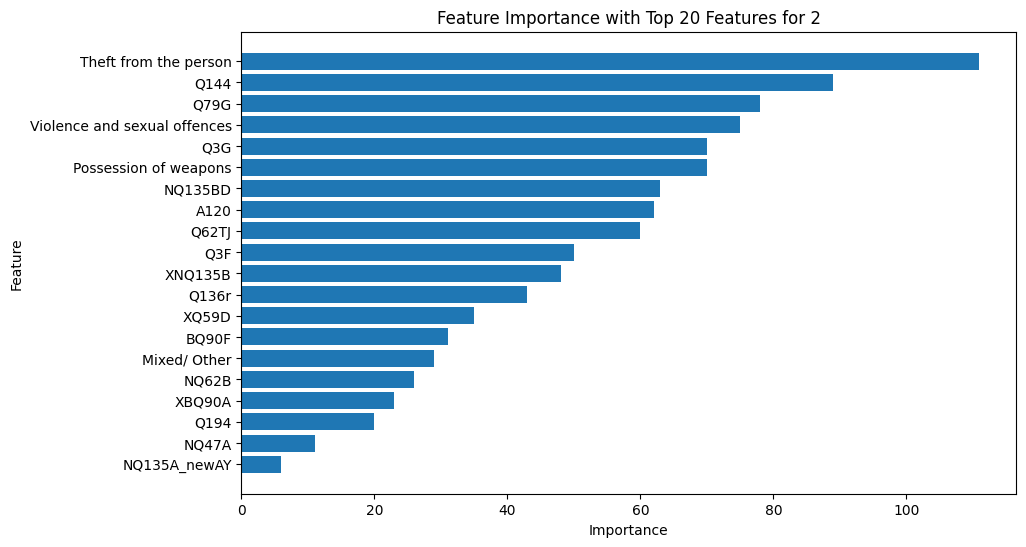

                         Feature  Importance
2          Theft from the person       111.0
5                           Q144        89.0
11                          Q79G        78.0
17  Violence and sexual offences        75.0
0                            Q3G        70.0
4          Possession of weapons        70.0
6                        NQ135BD        63.0
12                          A120        62.0
8                          Q62TJ        60.0
10                           Q3F        50.0
18                       XNQ135B        48.0
15                         Q136r        43.0
3                          XQ59D        35.0
9                          BQ90F        31.0
14                  Mixed/ Other        29.0
19                         NQ62B        26.0
1                         XBQ90A        23.0
16                          Q194        20.0
7                          NQ47A        11.0
13                  NQ135A_newAY         6.0
Processing borough: 26
Splitting data for borough: 26
C

Calculating Permutation Importance for 26: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 26:
Q62E: 0.0045
Q62TG: 0.0043
NQ135BH: 0.0035
SQ80D: 0.0024
ReQ139: 0.0021
Q3C: 0.0020
Vehicle crime: 0.0018
Q3K: 0.0017
NQ79BB: 0.0015
NQ62A: 0.0015
XQ59D: 0.0014
NQ135BF: 0.0013
Drugs: 0.0012
Q79F: 0.0012
SQ79B: 0.0012
NQ44A: 0.0011
Q79H: 0.0010
Q1: 0.0010
BQ90DA: 0.0009
BQ90B: 0.0009
[0]	train-rmse:0.71821	test-rmse:0.67061
[10]	train-rmse:0.50056	test-rmse:0.66336
[11]	train-rmse:0.48776	test-rmse:0.66590


RMSE on test set with top features for 26: 0.6695143336045916


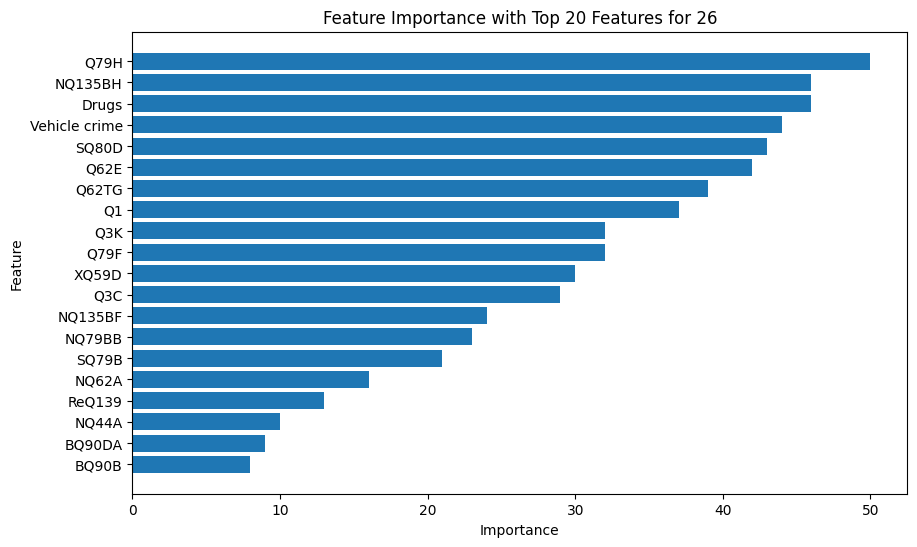

          Feature  Importance
16           Q79H        50.0
2         NQ135BH        46.0
12          Drugs        46.0
6   Vehicle crime        44.0
3           SQ80D        43.0
0            Q62E        42.0
1           Q62TG        39.0
17             Q1        37.0
7             Q3K        32.0
13           Q79F        32.0
10          XQ59D        30.0
5             Q3C        29.0
11        NQ135BF        24.0
8          NQ79BB        23.0
14          SQ79B        21.0
9           NQ62A        16.0
4          ReQ139        13.0
15          NQ44A        10.0
18         BQ90DA         9.0
19          BQ90B         8.0
Processing borough: 16
Splitting data for borough: 16
Converting data to DMatrix format for borough: 16
Training model for borough: 16
[0]	train-rmse:0.71785	test-rmse:0.73185
[10]	train-rmse:0.36785	test-rmse:0.60627
[18]	train-rmse:0.30266	test-rmse:0.61562
Making predictions for borough: 16
Calculating RMSE for borough: 16
RMSE for 16: 0.6154121398391306
Calculatin

Calculating Permutation Importance for 16: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 16:
NQ193B: 0.0028
SQ132P: 0.0027
NQ62D: 0.0027
Q1: 0.0023
Q9: 0.0022
XQ59A: 0.0021
Robbery: 0.0017
NQ79BI: 0.0016
Q59: 0.0014
Q54A: 0.0014
Q79H: 0.0013
XQ122B: 0.0013
NQ135BI: 0.0012
Q79D: 0.0011
NQ1: 0.0010
NQ49C: 0.0009
A121: 0.0009
White: 0.0009
SQ132NN: 0.0008
NQ62A: 0.0007
[0]	train-rmse:0.78288	test-rmse:0.80467
[10]	train-rmse:0.58794	test-rmse:0.77268
[17]	train-rmse:0.53526	test-rmse:0.77959


RMSE on test set with top features for 16: 0.779406424974395


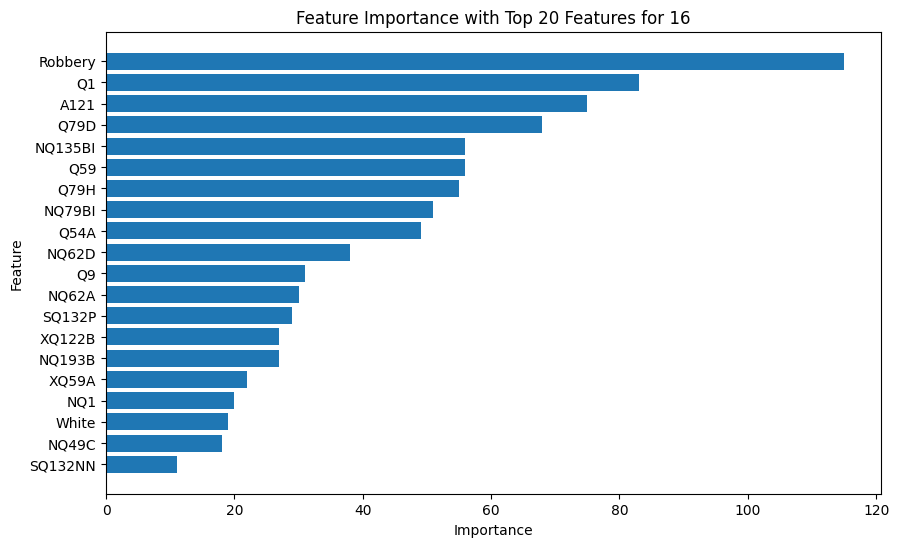

    Feature  Importance
6   Robbery       115.0
3        Q1        83.0
16     A121        75.0
13     Q79D        68.0
12  NQ135BI        56.0
8       Q59        56.0
10     Q79H        55.0
7    NQ79BI        51.0
9      Q54A        49.0
2     NQ62D        38.0
4        Q9        31.0
19    NQ62A        30.0
1    SQ132P        29.0
11   XQ122B        27.0
0    NQ193B        27.0
5     XQ59A        22.0
14      NQ1        20.0
17    White        19.0
15    NQ49C        18.0
18  SQ132NN        11.0
Processing borough: 4
Splitting data for borough: 4
Converting data to DMatrix format for borough: 4
Training model for borough: 4
[0]	train-rmse:0.73083	test-rmse:0.78123
[10]	train-rmse:0.35307	test-rmse:0.61884
[19]	train-rmse:0.28181	test-rmse:0.62291
Making predictions for borough: 4
Calculating RMSE for borough: 4
RMSE for 4: 0.6229146894434351
Calculating permutation importances for borough: 4


Calculating Permutation Importance for 4: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 4:
Q79A: 0.0069
A121: 0.0032
Mixed/ Other: 0.0031
NQ135A_newAE: 0.0026
Other theft: 0.0019
NQ57AA: 0.0018
Q196C: 0.0017
ZQ10I: 0.0015
NQ135BD: 0.0015
XQ122B: 0.0015
XQ81: 0.0015
Burglary: 0.0014
Q62E: 0.0014
Q3H: 0.0013
Anti-social behaviour: 0.0013
Theft from the person: 0.0011
Bicycle theft: 0.0011
IMDQuartile: 0.0011
ZNQ10BC: 0.0011
Q62C: 0.0010
[0]	train-rmse:0.78263	test-rmse:0.82914
[10]	train-rmse:0.53157	test-rmse:0.80376
[13]	train-rmse:0.51245	test-rmse:0.80488


RMSE on test set with top features for 4: 0.8070563862144012


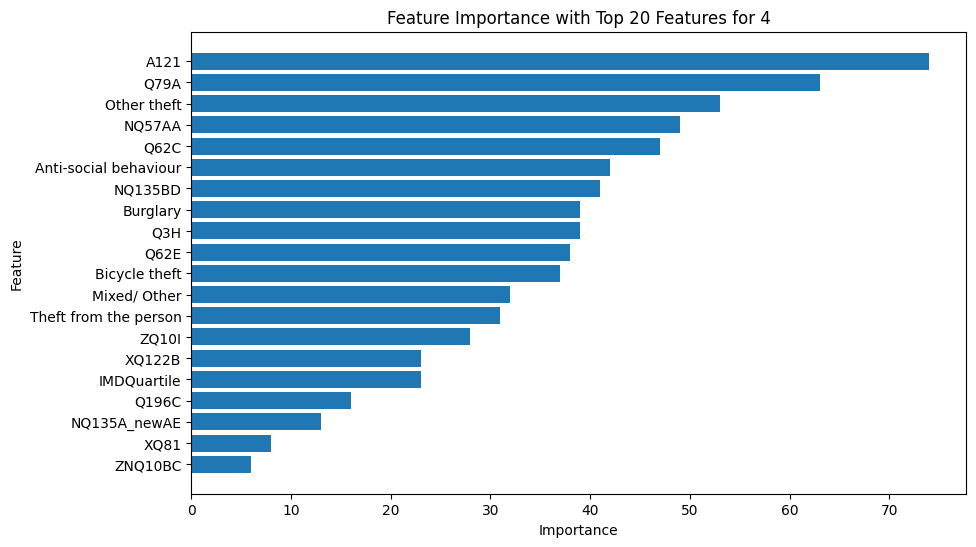

                  Feature  Importance
1                    A121        74.0
0                    Q79A        63.0
4             Other theft        53.0
5                  NQ57AA        49.0
19                   Q62C        47.0
14  Anti-social behaviour        42.0
8                 NQ135BD        41.0
11               Burglary        39.0
13                    Q3H        39.0
12                   Q62E        38.0
16          Bicycle theft        37.0
2            Mixed/ Other        32.0
15  Theft from the person        31.0
7                   ZQ10I        28.0
9                  XQ122B        23.0
17            IMDQuartile        23.0
6                   Q196C        16.0
3            NQ135A_newAE        13.0
10                   XQ81         8.0
18                ZNQ10BC         6.0
Processing borough: 8
Splitting data for borough: 8
Converting data to DMatrix format for borough: 8
Training model for borough: 8
[0]	train-rmse:0.70359	test-rmse:0.72009
[10]	train-rmse:0.38280	test-r

Calculating Permutation Importance for 8: 100%|██████████| 597/597 [08:41<00:00,  1.14it/s]

Top 20 Feature Importance for 8:
Q62E: 0.0046
Criminal damage and arson: 0.0042
NQ135BD: 0.0033
Q144: 0.0030
Q3I: 0.0028
Violence and sexual offences: 0.0026
Other crime: 0.0025
NQ57AC: 0.0023
Q21: 0.0023
SQ79C: 0.0022
Q66: 0.0022
Q3C: 0.0019
Bicycle theft: 0.0014
ZQ10J: 0.0013
Q79H: 0.0012
NNQ135A: 0.0012
ZQ10B: 0.0012
Q79G: 0.0012
Q119: 0.0012
NQ46A: 0.0010
[0]	train-rmse:0.75169	test-rmse:0.77363
[10]	train-rmse:0.52118	test-rmse:0.73661
[13]	train-rmse:0.48449	test-rmse:0.74734


RMSE on test set with top features for 8: 0.7510028953295347


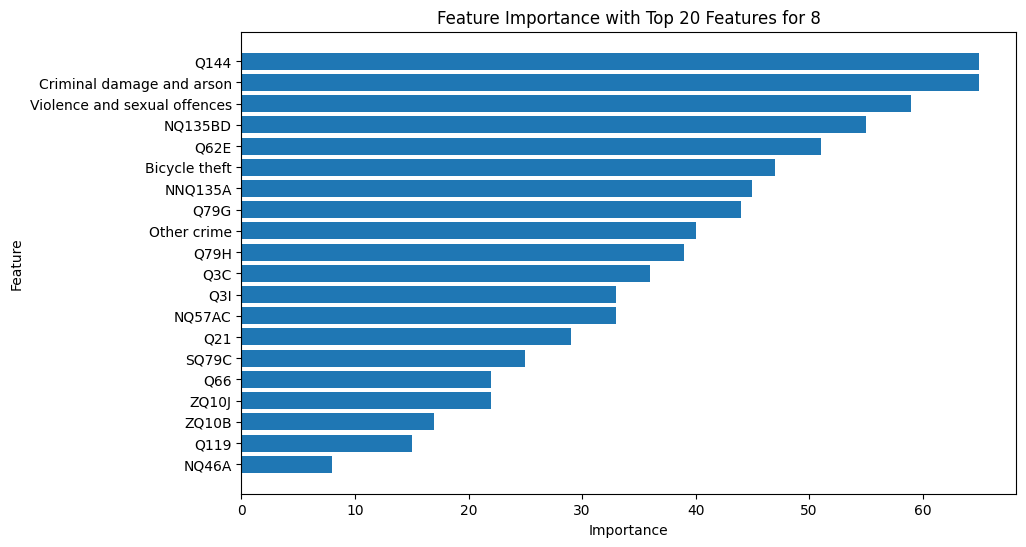

                         Feature  Importance
3                           Q144        65.0
1      Criminal damage and arson        65.0
5   Violence and sexual offences        59.0
2                        NQ135BD        55.0
0                           Q62E        51.0
12                 Bicycle theft        47.0
15                       NNQ135A        45.0
17                          Q79G        44.0
6                    Other crime        40.0
14                          Q79H        39.0
11                           Q3C        36.0
4                            Q3I        33.0
7                         NQ57AC        33.0
8                            Q21        29.0
9                          SQ79C        25.0
10                           Q66        22.0
13                         ZQ10J        22.0
16                         ZQ10B        17.0
18                          Q119        15.0
19                         NQ46A         8.0
Processing borough: 31
Splitting data for borough: 31
C

Calculating Permutation Importance for 31: 100%|██████████| 597/597 [08:42<00:00,  1.14it/s]

Top 20 Feature Importance for 31:
NQ79BI: 0.0110
NQ21: 0.0057
Other crime: 0.0056
NQCV13: 0.0029
NNQ27C: 0.0028
Q139r: 0.0027
Possession of weapons: 0.0022
NQ43: 0.0020
XNQ135B: 0.0018
Drugs: 0.0017
Shoplifting: 0.0016
Q3J: 0.0015
PQ135AC: 0.0014
Q65: 0.0013
SQ79EF: 0.0013
Anti-social behaviour: 0.0012
XQ128C: 0.0012
XQ57D: 0.0012
Q132GG: 0.0012
XQ8: 0.0011
[0]	train-rmse:0.72806	test-rmse:0.76604
[10]	train-rmse:0.56435	test-rmse:0.73048
[19]	train-rmse:0.51476	test-rmse:0.74294


RMSE on test set with top features for 31: 0.7429387724377744


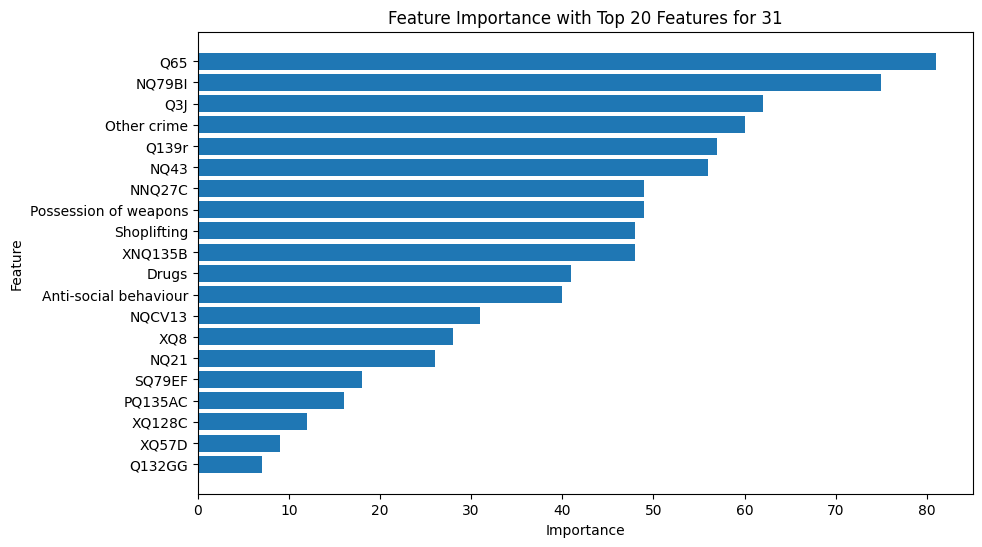

                  Feature  Importance
13                    Q65        81.0
0                  NQ79BI        75.0
11                    Q3J        62.0
2             Other crime        60.0
5                   Q139r        57.0
7                    NQ43        56.0
4                  NNQ27C        49.0
6   Possession of weapons        49.0
10            Shoplifting        48.0
8                 XNQ135B        48.0
9                   Drugs        41.0
15  Anti-social behaviour        40.0
3                  NQCV13        31.0
19                    XQ8        28.0
1                    NQ21        26.0
14                 SQ79EF        18.0
12                PQ135AC        16.0
16                 XQ128C        12.0
17                  XQ57D         9.0
18                 Q132GG         7.0
Processing borough: 29
Splitting data for borough: 29
Converting data to DMatrix format for borough: 29
Training model for borough: 29
[0]	train-rmse:0.71653	test-rmse:0.71417
[10]	train-rmse:0.31752	te

Calculating Permutation Importance for 29: 100%|██████████| 597/597 [08:43<00:00,  1.14it/s]

Top 20 Feature Importance for 29:
SQ80E: 0.0079
Q3G: 0.0078
SQ80F: 0.0072
SQ80D: 0.0042
Q1: 0.0038
NQ57AE: 0.0035
Q3H: 0.0032
Q79E: 0.0029
NQ57AB: 0.0029
NQ7B: 0.0025
NQ44BE: 0.0023
NQ135BH: 0.0022
Burglary: 0.0020
Q65: 0.0020
XQ128A2A: 0.0015
Q79C: 0.0013
ReQ136: 0.0012
XQ119A: 0.0012
Criminal damage and arson: 0.0012
PQ135AAX: 0.0012
[0]	train-rmse:0.79540	test-rmse:0.77811
[10]	train-rmse:0.56065	test-rmse:0.75009
[14]	train-rmse:0.53434	test-rmse:0.76109


RMSE on test set with top features for 29: 0.7626442503970289


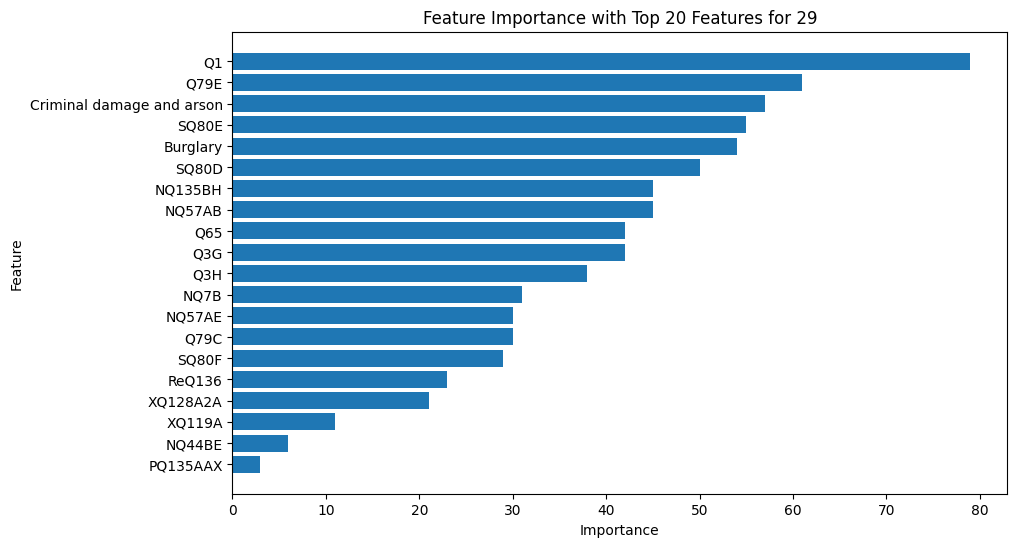

                      Feature  Importance
4                          Q1        79.0
7                        Q79E        61.0
18  Criminal damage and arson        57.0
0                       SQ80E        55.0
12                   Burglary        54.0
3                       SQ80D        50.0
11                    NQ135BH        45.0
8                      NQ57AB        45.0
13                        Q65        42.0
1                         Q3G        42.0
6                         Q3H        38.0
9                        NQ7B        31.0
5                      NQ57AE        30.0
15                       Q79C        30.0
2                       SQ80F        29.0
16                     ReQ136        23.0
14                   XQ128A2A        21.0
17                     XQ119A        11.0
10                     NQ44BE         6.0
19                   PQ135AAX         3.0
Processing borough: 12
Splitting data for borough: 12
Converting data to DMatrix format for borough: 12
Training model

Calculating Permutation Importance for 12: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 12:
Q3L: 0.0059
NQ135BD: 0.0052
Q3K: 0.0049
Q79C: 0.0027
NQ62D: 0.0027
NQ135BB: 0.0024
NNQ135A: 0.0021
ZQ10A: 0.0018
Other theft: 0.0018
Bicycle theft: 0.0016
Drugs: 0.0016
ReQ139: 0.0016
Q3H: 0.0016
Q62H: 0.0015
ZQ10I: 0.0012
NQ7B: 0.0011
Q59: 0.0009
XQ135r: 0.0009
NQCV21: 0.0009
Q132P: 0.0009
[0]	train-rmse:0.66754	test-rmse:0.65840
[10]	train-rmse:0.47340	test-rmse:0.65393
[12]	train-rmse:0.45252	test-rmse:0.65773


RMSE on test set with top features for 12: 0.65773208920316


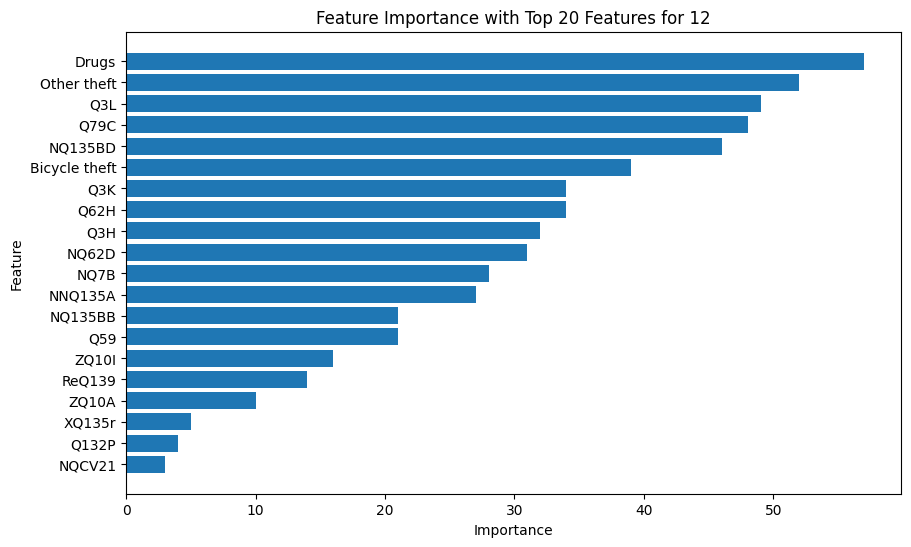

          Feature  Importance
10          Drugs        57.0
8     Other theft        52.0
0             Q3L        49.0
3            Q79C        48.0
1         NQ135BD        46.0
9   Bicycle theft        39.0
2             Q3K        34.0
13           Q62H        34.0
12            Q3H        32.0
4           NQ62D        31.0
15           NQ7B        28.0
6         NNQ135A        27.0
5         NQ135BB        21.0
16            Q59        21.0
14          ZQ10I        16.0
11         ReQ139        14.0
7           ZQ10A        10.0
17         XQ135r         5.0
19          Q132P         4.0
18         NQCV21         3.0
Processing borough: 32
Splitting data for borough: 32
Converting data to DMatrix format for borough: 32
Training model for borough: 32
[0]	train-rmse:0.65346	test-rmse:0.74154
[10]	train-rmse:0.31828	test-rmse:0.62331
[19]	train-rmse:0.25099	test-rmse:0.62787
Making predictions for borough: 32
Calculating RMSE for borough: 32
RMSE for 32: 0.6278686570030743
Calculatin

Calculating Permutation Importance for 32: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 32:
Q13: 0.0051
NQ43: 0.0045
Q62E: 0.0043
Other crime: 0.0040
Bicycle theft: 0.0032
NQCV9: 0.0030
Q62B: 0.0028
Q3K: 0.0024
Q62TG: 0.0023
Q3F: 0.0022
Shoplifting: 0.0021
Q62C: 0.0020
ReQ139: 0.0019
NQCV27: 0.0019
Q15: 0.0016
IMDQuartile: 0.0016
NQ135BDD: 0.0015
Q54A: 0.0014
ZNQ10BD: 0.0013
NQ135BH: 0.0012
[0]	train-rmse:0.70377	test-rmse:0.78604
[10]	train-rmse:0.48001	test-rmse:0.73678
[17]	train-rmse:0.42843	test-rmse:0.74868


RMSE on test set with top features for 32: 0.7486833074844547


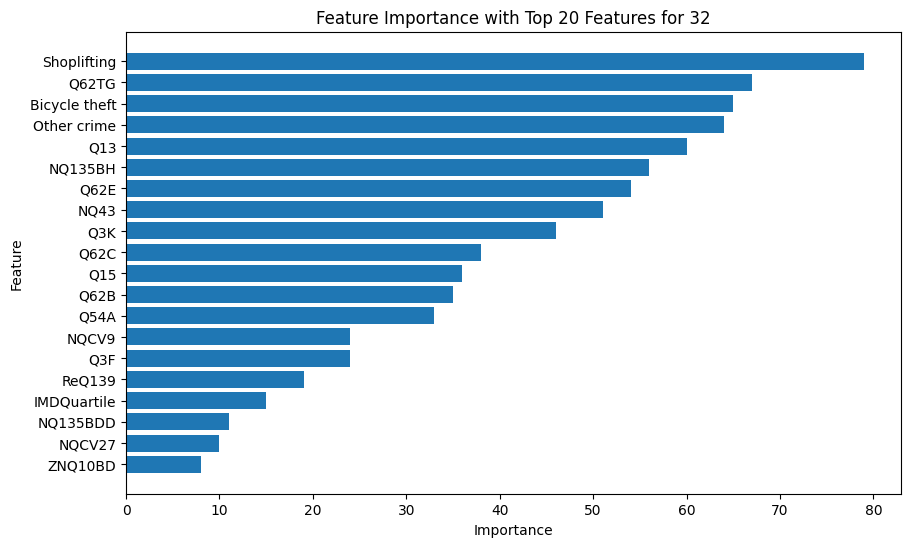

          Feature  Importance
10    Shoplifting        79.0
8           Q62TG        67.0
4   Bicycle theft        65.0
3     Other crime        64.0
0             Q13        60.0
19        NQ135BH        56.0
2            Q62E        54.0
1            NQ43        51.0
7             Q3K        46.0
11           Q62C        38.0
14            Q15        36.0
6            Q62B        35.0
17           Q54A        33.0
5           NQCV9        24.0
9             Q3F        24.0
12         ReQ139        19.0
15    IMDQuartile        15.0
16       NQ135BDD        11.0
13         NQCV27        10.0
18        ZNQ10BD         8.0
Processing borough: 19
Splitting data for borough: 19
Converting data to DMatrix format for borough: 19
Training model for borough: 19
[0]	train-rmse:0.60207	test-rmse:0.64385
[10]	train-rmse:0.29629	test-rmse:0.53152
[19]	train-rmse:0.24951	test-rmse:0.53912
Making predictions for borough: 19
Calculating RMSE for borough: 19
RMSE for 19: 0.5391204343740225
Calculatin

Calculating Permutation Importance for 19: 100%|██████████| 597/597 [08:51<00:00,  1.12it/s]

Top 20 Feature Importance for 19:
Q58: 0.0031
SQ79ED: 0.0029
NQ135BC: 0.0020
NQ7B: 0.0020
Violence and sexual offences: 0.0020
Vehicle crime: 0.0020
Month_Number: 0.0019
Q62F: 0.0019
Q79B: 0.0019
TQ132: 0.0017
NQCV11: 0.0016
Q131: 0.0016
SQ79EB: 0.0015
Q79H: 0.0014
NQ193B: 0.0014
Q3J: 0.0013
Q3K: 0.0013
ReXQ135: 0.0013
NQ43: 0.0013
NQ2F: 0.0011
[0]	train-rmse:0.65650	test-rmse:0.68654
[10]	train-rmse:0.47158	test-rmse:0.63694
[16]	train-rmse:0.42966	test-rmse:0.64552


RMSE on test set with top features for 19: 0.645134729681691


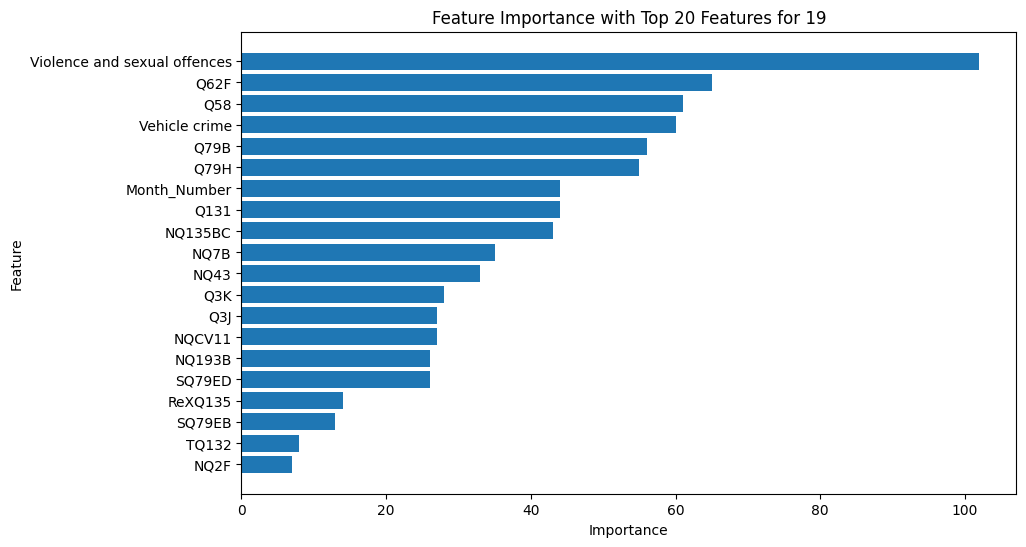

                         Feature  Importance
4   Violence and sexual offences       102.0
7                           Q62F        65.0
0                            Q58        61.0
5                  Vehicle crime        60.0
8                           Q79B        56.0
13                          Q79H        55.0
6                   Month_Number        44.0
11                          Q131        44.0
2                        NQ135BC        43.0
3                           NQ7B        35.0
18                          NQ43        33.0
16                           Q3K        28.0
15                           Q3J        27.0
10                        NQCV11        27.0
14                        NQ193B        26.0
1                         SQ79ED        26.0
17                       ReXQ135        14.0
12                        SQ79EB        13.0
9                          TQ132         8.0
19                          NQ2F         7.0
Processing borough: 30
Splitting data for borough: 30
C

Calculating Permutation Importance for 30: 100%|██████████| 597/597 [08:44<00:00,  1.14it/s]

Top 20 Feature Importance for 30:
Public order: 0.0046
ReQ136: 0.0017
Q1: 0.0017
Vehicle crime: 0.0017
Q3G: 0.0015
XQ128A2A: 0.0015
NQ135BF: 0.0014
XQ59A: 0.0014
PQ135AB: 0.0013
XQ128A2B: 0.0013
Q62H: 0.0012
Q62C: 0.0012
NQ135BDD: 0.0012
NQ135B_newN: 0.0011
XQ8: 0.0011
XQ106B: 0.0011
Criminal damage and arson: 0.0011
SQ79EG: 0.0011
A120: 0.0010
Q132G: 0.0010
[0]	train-rmse:0.78134	test-rmse:0.80177
[10]	train-rmse:0.58032	test-rmse:0.72593
[17]	train-rmse:0.52433	test-rmse:0.73187


RMSE on test set with top features for 30: 0.7316059463057679


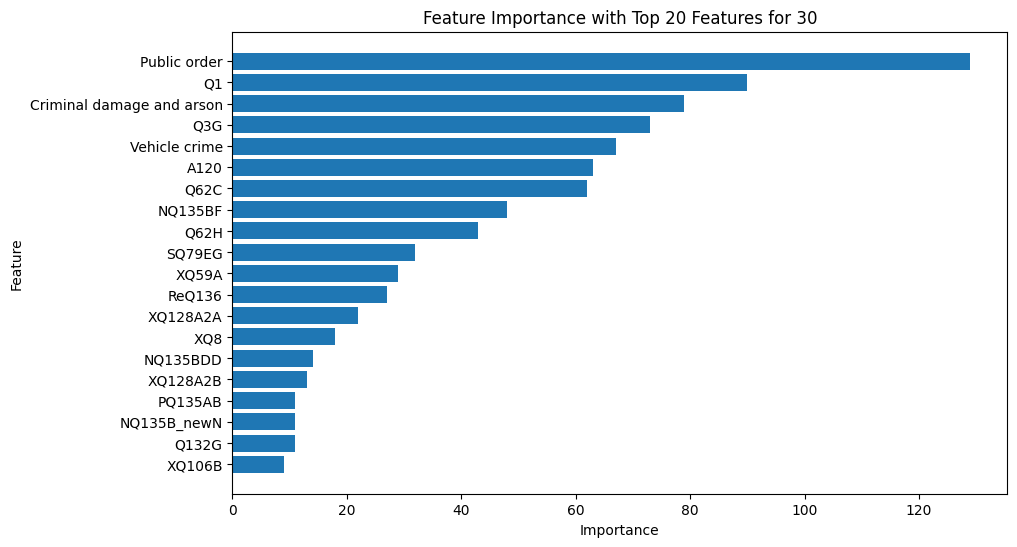

                      Feature  Importance
0                Public order       129.0
2                          Q1        90.0
16  Criminal damage and arson        79.0
4                         Q3G        73.0
3               Vehicle crime        67.0
18                       A120        63.0
11                       Q62C        62.0
6                     NQ135BF        48.0
10                       Q62H        43.0
17                     SQ79EG        32.0
7                       XQ59A        29.0
1                      ReQ136        27.0
5                    XQ128A2A        22.0
14                        XQ8        18.0
12                   NQ135BDD        14.0
9                    XQ128A2B        13.0
8                     PQ135AB        11.0
13                NQ135B_newN        11.0
19                      Q132G        11.0
15                     XQ106B         9.0
Processing borough: 11
Splitting data for borough: 11
Converting data to DMatrix format for borough: 11
Training model

Calculating Permutation Importance for 11: 100%|██████████| 597/597 [08:45<00:00,  1.14it/s]

Top 20 Feature Importance for 11:
NQ57AB: 0.0088
NQ57AC: 0.0021
A121: 0.0018
SQ80D: 0.0016
Q79H: 0.0015
Q14B: 0.0014
XQ81A: 0.0013
XQ128A2D: 0.0013
NQ147r: 0.0012
Bicycle theft: 0.0012
Q39BB: 0.0012
Possession of weapons: 0.0011
NQ79BB: 0.0011
Q1: 0.0010
Q54B: 0.0010
Q3J: 0.0010
Asian: 0.0009
NQ135BH: 0.0009
NQ7B: 0.0009
Q10A: 0.0008
[0]	train-rmse:0.78991	test-rmse:0.84573
[10]	train-rmse:0.58704	test-rmse:0.82259
[20]	train-rmse:0.49451	test-rmse:0.84392


RMSE on test set with top features for 11: 0.8439210215732884


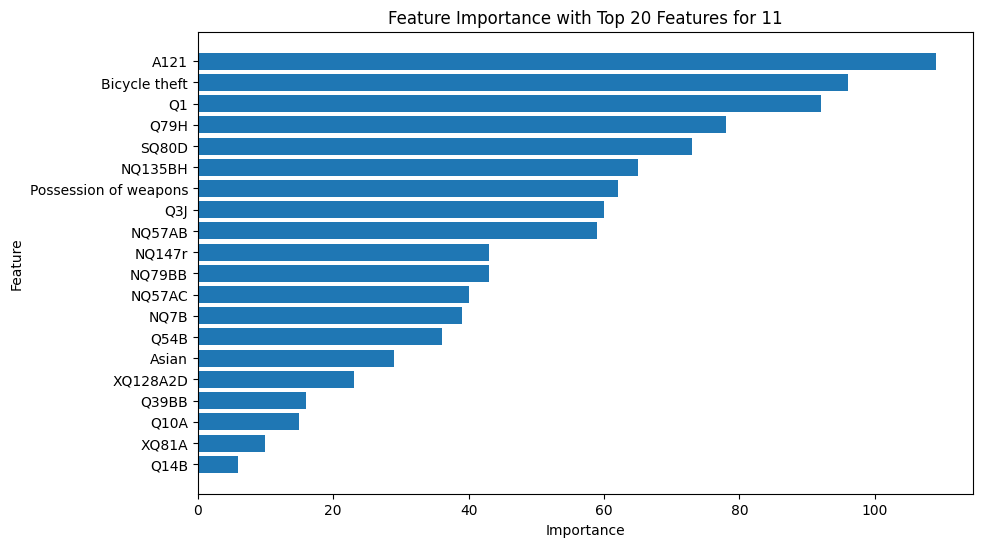

                  Feature  Importance
2                    A121       109.0
9           Bicycle theft        96.0
13                     Q1        92.0
4                    Q79H        78.0
3                   SQ80D        73.0
17                NQ135BH        65.0
11  Possession of weapons        62.0
15                    Q3J        60.0
0                  NQ57AB        59.0
8                  NQ147r        43.0
12                 NQ79BB        43.0
1                  NQ57AC        40.0
18                   NQ7B        39.0
14                   Q54B        36.0
16                  Asian        29.0
7                XQ128A2D        23.0
10                  Q39BB        16.0
19                   Q10A        15.0
6                   XQ81A        10.0
5                    Q14B         6.0
Processing borough: 6
Splitting data for borough: 6
Converting data to DMatrix format for borough: 6
Training model for borough: 6
[0]	train-rmse:0.69331	test-rmse:0.69763
[10]	train-rmse:0.31924	test-r

Calculating Permutation Importance for 6: 100%|██████████| 597/597 [08:46<00:00,  1.13it/s]

Top 20 Feature Importance for 6:
Q3H: 0.0051
Q62F: 0.0031
NQ135BD: 0.0027
PQ135AF: 0.0026
Q62B: 0.0022
Q144: 0.0021
ZQ10I: 0.0020
Other theft: 0.0020
NQ135BDE: 0.0019
Q195B: 0.0019
NQ193A: 0.0018
IMDQuartile: 0.0016
Burglary: 0.0016
Q79C: 0.0016
NNQ135A: 0.0016
NQ79BB: 0.0016
Q66: 0.0016
Q21: 0.0015
Q13: 0.0014
Q65: 0.0014
[0]	train-rmse:0.74540	test-rmse:0.75502
[10]	train-rmse:0.49014	test-rmse:0.72129
[14]	train-rmse:0.46459	test-rmse:0.72541


RMSE on test set with top features for 6: 0.7279331398141322


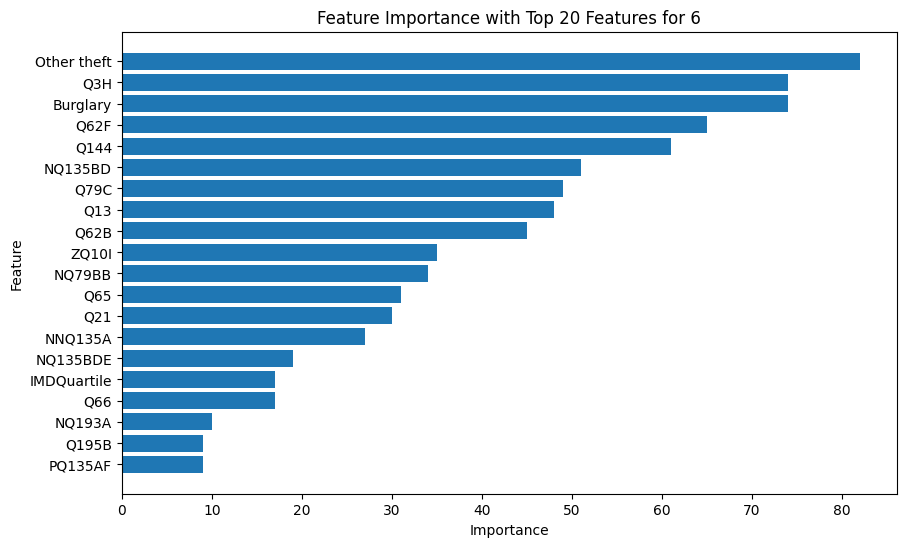

        Feature  Importance
7   Other theft        82.0
0           Q3H        74.0
12     Burglary        74.0
1          Q62F        65.0
5          Q144        61.0
2       NQ135BD        51.0
13         Q79C        49.0
18          Q13        48.0
4          Q62B        45.0
6         ZQ10I        35.0
15       NQ79BB        34.0
19          Q65        31.0
17          Q21        30.0
14      NNQ135A        27.0
8      NQ135BDE        19.0
11  IMDQuartile        17.0
16          Q66        17.0
10       NQ193A        10.0
9         Q195B         9.0
3       PQ135AF         9.0
RMSE for all boroughs:
18: 0.5806216491047764
28: 0.6009976004732682
5: 0.6046500208416397
22: 0.6154709193400142
3: 0.5903747684436389
13: 0.6150411861419453
14: 0.6065040452028692
9: 0.6350460936942562
7: 0.6349184914281577
24: 0.6595789528078687
1: 0.6335350033297404
15: 0.665536796101502
25: 0.5926444111918556
27: 0.6157272228539608
21: 0.6254999212060408
17: 0.6083410915114519
10: 0.5699547266219952
20: 

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Load the data
print("Loading data...")
df = pd.read_csv('../project_data/PAS+crime+extra_final.csv')

# Drop rows where 'Q60' is NaN and filter out 'Q60' values >= 95
print("Cleaning data...")
df.dropna(subset=['Q60'], inplace=True)
df = df[df['Q60'] < 95]

# Removing columns that are named 'WT...'
columns_to_drop = df.filter(regex='^WT_').columns
df = df.drop(columns=columns_to_drop)

# Define features and target
print("Defining features and target...")
X = df.drop(columns='Q60')
y = df['Q60']

# Get unique boroughs
print("Identifying unique boroughs...")
boroughs = df['Borough'].unique()
print(f"Found {len(boroughs)} unique boroughs.")

# Dictionary to store models, results, and feature importances
models = {}
evals_results = {}
rmses = {}
perm_importances_dict = {}
top_features_dict = {}

# Iterate over each borough and train a model
for borough in boroughs:
    print(f"Processing borough: {borough}")
    
    # Filter the data for the current borough
    borough_data = df[df['Borough'] == borough]
    X_borough = borough_data.drop(columns=['Q60', 'Borough'])
    y_borough = borough_data['Q60']
    
    # Split the data into training and testing sets
    print(f"Splitting data for borough: {borough}")
    X_train, X_test, y_train, y_test = train_test_split(X_borough, y_borough, test_size=0.2, random_state=42)
    
    # Convert data into DMatrix format for XGBoost
    print(f"Converting data to DMatrix format for borough: {borough}")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Define parameters
    params = {
        'objective': 'reg:squarederror',  # Use squared error for regression task
        'random_state': 42
    }
    
    # Train the model
    print(f"Training model for borough: {borough}")
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)
    
    # Make predictions on the test set
    print(f"Making predictions for borough: {borough}")
    y_pred = model.predict(dtest)
    
    # Calculate and store RMSE
    print(f"Calculating RMSE for borough: {borough}")
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store the model, evals_result, and RMSE
    models[borough] = model
    evals_results[borough] = {'test': {'X': X_test, 'y': y_test}}
    rmses[borough] = rmse
    
    print(f"RMSE for {borough}: {rmse}")
    
    # Permutation Importance Calculation
    print(f"Calculating permutation importances for borough: {borough}")
    baseline_rmse = rmse
    perm_importances = np.zeros(X_test.shape[1])
    np.random.seed(42)
    n_permutations = 10
    
    for i in tqdm(range(X_test.shape[1]), desc=f"Calculating Permutation Importance for {borough}"):
        perm_importances_temp = []
        for _ in range(n_permutations):
            X_test_permuted = X_test.copy()
            X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
            y_pred_permuted = model.predict(xgb.DMatrix(X_test_permuted))
            permuted_rmse = root_mean_squared_error(y_test, y_pred_permuted)
            perm_importance = baseline_rmse - permuted_rmse
            perm_importances_temp.append(perm_importance)
        perm_importances[i] = np.mean(perm_importances_temp)
    
    perm_importances_dict[borough] = perm_importances
    sorted_idx = np.argsort(perm_importances)[::-1]
    
    # Print the top 20 features by permutation importance
    print(f"Top 20 Feature Importance for {borough}:")
    for i in sorted_idx[:20]:
        print(f"{X_borough.columns[i]}: {perm_importances[i]:.4f}")
    
    # Select the top 20 most important features
    top_features = X_borough.columns[sorted_idx[:20]]
    top_features_dict[borough] = top_features
    
    # Create a new DataFrame with only the top features
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]
    
    # Retrain the model using only the top features
    dtrain_top = xgb.DMatrix(X_train_top, label=y_train)
    dtest_top = xgb.DMatrix(X_test_top, label=y_test)
    
    model_top = xgb.train(params, dtrain_top, num_boost_round=100,
                          evals=[(dtrain_top, 'train'), (dtest_top, 'test')],
                          early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)
    
    # Make predictions on the test set with the top features
    y_pred_top = model_top.predict(dtest_top)
    
    # Calculate and print RMSE on the test set with the top features
    rmse_top = root_mean_squared_error(y_test, y_pred_top)
    print(f"RMSE on test set with top features for {borough}: {rmse_top}")
    
    # Get feature importance scores
    feature_importance = model_top.get_score(importance_type='weight')
    
    # Convert to DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance with Top 20 Features for {borough}')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Print feature importance
    print(importance_df)

# Print all RMSes
print("RMSE for all boroughs:")
for borough, rmse in rmses.items():
    print(f"{borough}: {rmse}")
